In [1]:
from salishsea_tools import viz_tools
import numpy as np
import matplotlib.pyplot as plt
# import pandas as pd
import xarray as xr
import cmocean.cm as cm
# import glob
from sklearn.decomposition import PCA
import sys

In [2]:
sys.path.insert(1, '../../../../MEOPAR/tools/SalishSeaTools/salishsea_tools/')
import river_202108 as rivers

In [3]:
physics_202111 = xr.open_dataset('/ocean/cdonaldson/compare_daily_river/SalishSeaCast_day_avg_physics_20190101_20191231.nc')

Text(0.5, 0.98, 'Salinity at 0.5 m (g/kg) 202111')

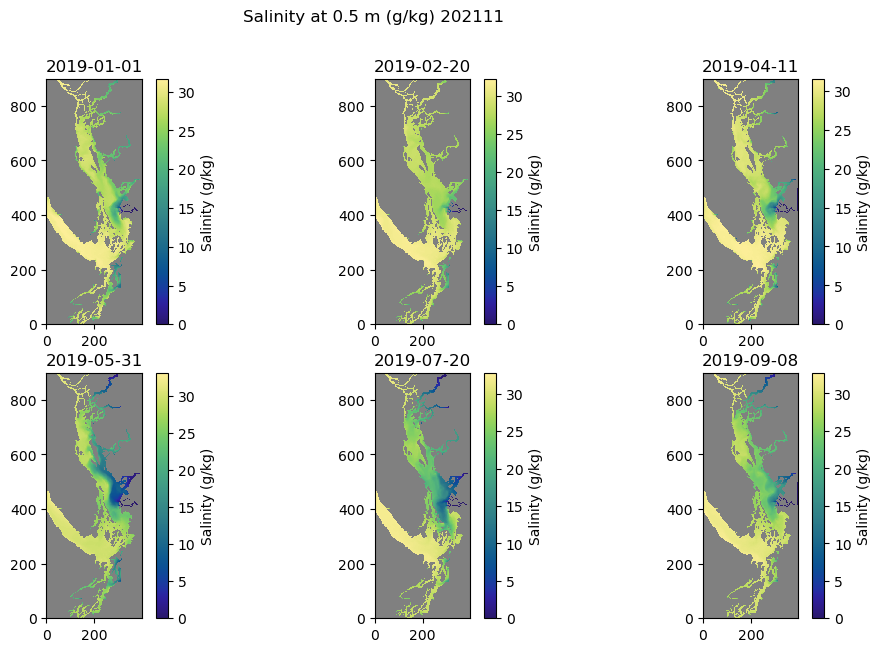

In [4]:
## PRE-PROCESSING PART
phys_arr = physics_202111.vosaline.to_numpy()

# make the indicies for plotting six sample salinity fields
plot_ind = np.array([[0,0], [0,1], [0,2], [1,0], [1,1], [1,2]])
plot_day = np.array([0, 50, 100, 150, 200, 250])  # this selects what days of each year to plot, change for > 1 year

# open the mesh mask and use it to mask the land
# mesh = xr.open_dataset('../../../../MEOPAR/grid/mesh_mask201702.nc')
mesh = xr.open_dataset('../../../../MEOPAR/grid/mesh_mask202108.nc')
# the mask is 1 where there is water, we want the opposite.  The meshmask has an extra dimension, hence the [0]
tmask = 1 - mesh.tmask[0]

kd = 0 ## this will stay for surface
imin = 0
imax = 898
jmin = 0
jmax = 398
dm = physics_202111

fig1, ax1 = plt.subplots(2, 3, figsize=(12, 7))


## SHOWS SALINITY PLOTS
for i in np.arange(0,6):
    
    cmap = cm.haline
    cmap.set_bad('gray')

    
    day = plot_day[i]
    day_str = np.datetime_as_string(physics_202111.time[day].values, unit='D')
    # salinity plot
    myarray = np.ma.array(dm.vosaline[day, kd, imin:imax, jmin:jmax])
    salinity = np.ma.masked_array(myarray, mask=tmask[0])
    colours = ax1[plot_ind[i][0], plot_ind[i][1]].pcolormesh(np.arange(jmin, jmax), np.arange(imin, imax), salinity, cmap=cm.haline, shading='auto')
    ax1[plot_ind[i][0], plot_ind[i][1]].set_title(day_str)
    cb = fig1.colorbar(colours, ax=ax1[plot_ind[i][0], plot_ind[i][1]])
    cb.set_label('Salinity (g/kg)')
    viz_tools.set_aspect(ax1[plot_ind[i][0], plot_ind[i][1]]);

    
    
fig1.suptitle(f'Salinity at {kd+0.5} m (g/kg) ' + '202111')
# plt.savefig('2020_samplesal.png')



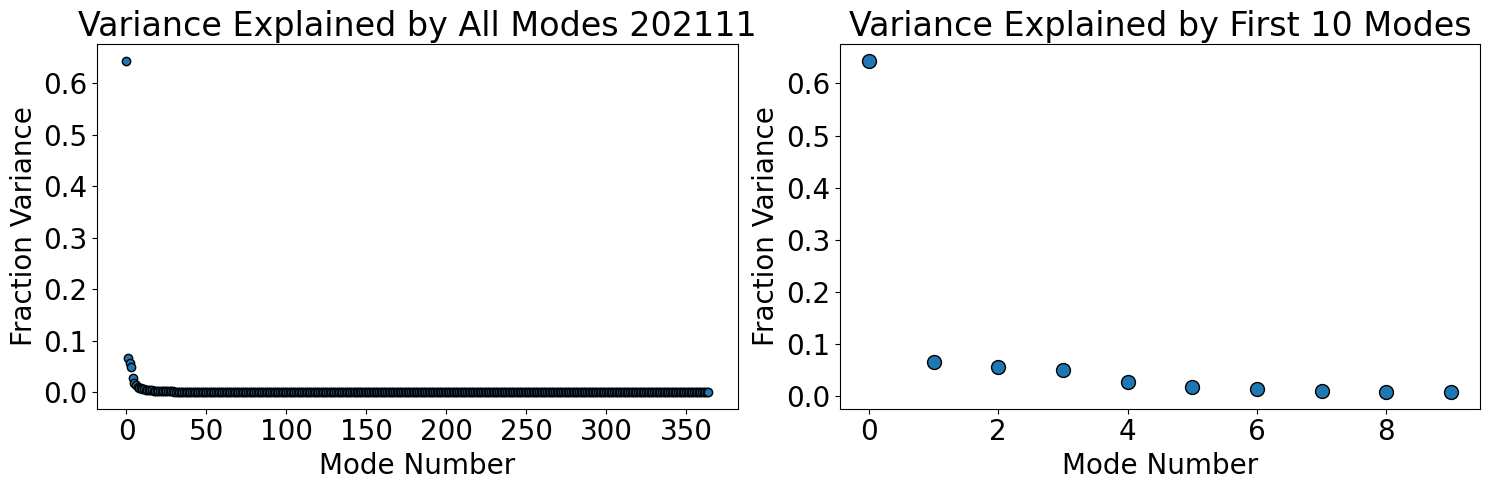

In [5]:
# define dimensions for later reshaping
num_days = phys_arr.shape[0]

Ny = phys_arr.shape[2]
Nx = phys_arr.shape[3]

## DO PCA PART
surface = phys_arr[:,0,:,:].reshape(num_days, 357404)  # TODO: FIX THIS to not hard coded
surface = np.nan_to_num(surface)

# does the PCA part
n_modes = np.min(np.shape(surface))
pca = PCA(n_components = n_modes)
PCs = pca.fit_transform(surface)
eigvecs = pca.components_
fracVar = pca.explained_variance_ratio_

#plot fraction of variance explained by each mode
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.scatter(range(len(fracVar)),fracVar, edgecolor = 'k')
plt.xlabel('Mode Number', fontsize = 20)
plt.ylabel('Fraction Variance', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Variance Explained by All Modes ' + '202111', fontsize = 24)

plt.subplot(1,2,2)
n_modes_show = 10  # TODO change this to fun input
plt.scatter(range(n_modes_show),fracVar[:n_modes_show], s = 100, edgecolor = 'k')
plt.xlabel('Mode Number', fontsize = 20)
plt.ylabel('Fraction Variance', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Variance Explained by First ' + str(n_modes_show) + ' Modes', fontsize = 24)

plt.tight_layout()

# if saveIt:
#     plt.savefig('tutorial4_fig3.png')

plt.show()

In [6]:
## access the PCA results
fracVar = pca.explained_variance_ratio_
eigvecs = pca.components_
PCs = pca.fit_transform(surface)
max_pc = PCs[:,0].max()

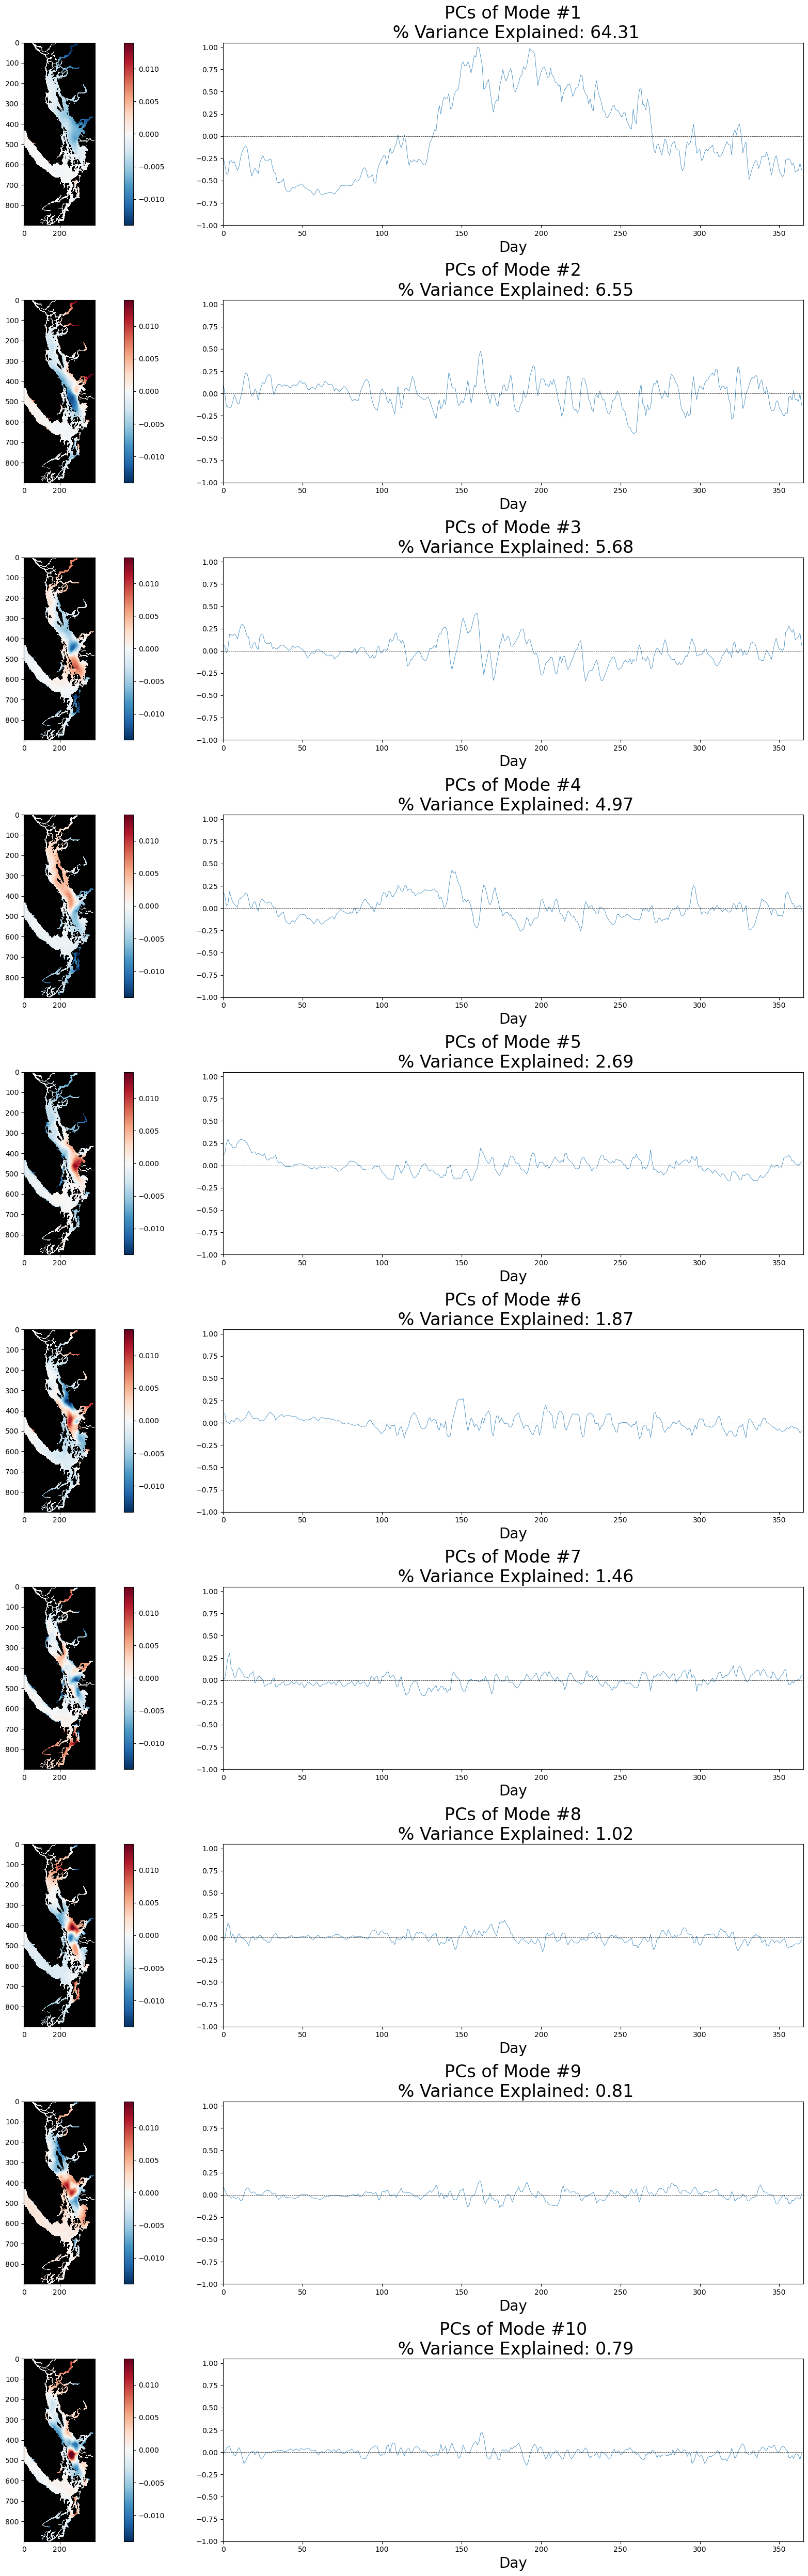

In [7]:
n = 10

# ## access the PCA results
# fracVar = pca.explained_variance_ratio_
# eigvecs = pca.components_
# PCs = pca.fit_transform(surface)

np.sum(fracVar[:n]) # fraction of variance explained by this maNx modes  #TODO change this also to fn input, is the same n as below

# make a mask of land where land is true and water in NaN
# bathymetry = xr.open_dataset('../../../../MEOPAR/grid/bathymetry_201702.nc')
bathymetry = xr.open_dataset('../../../../MEOPAR/grid/bathymetry_202108.nc')
land = np.array(np.isnan(bathymetry.Bathymetry).to_numpy(), dtype='float')
land[land == 0] = np.nan

# open the mesh mask and use it to mask the land
# mesh = xr.open_dataset('../../../../MEOPAR/grid/mesh_mask201702.nc')
mesh = xr.open_dataset('../../../../MEOPAR/grid/mesh_mask202108.nc')
# the mask is 1 where there is water, we want the opposite.  The meshmask has an extra dimension, hence the [0]
tmask = 1 - mesh.tmask[0]

#plot the first n modes and PCs -- choose a value of 'n' from the variance explained figure

fig2, ax2 = plt.subplots(n, 2, figsize=(23, 5*n))

for kk in range(n):
    
    plt.subplot(n,2,kk*2+1)
    to_show = np.ma.masked_array(np.flipud(np.reshape(eigvecs[kk],(Ny,Nx))), mask=tmask[0])
    cb = ax2[kk,0].pcolormesh(np.flipud(np.reshape(eigvecs[kk],(Ny,Nx))), cmap='RdBu_r',vmin=-0.014,vmax=0.014)
    plt.colorbar(cb)
    cb2 = ax2[kk,0].pcolormesh(np.flipud(land), cmap='copper')  ################## want
    # ax2[kk,0].set_ylim(0,898)
    ax2[kk,0].invert_yaxis()
    viz_tools.set_aspect(ax2[kk,0]);
    
    
    ax2[kk,1].plot(PCs[:,kk]/max_pc, linewidth = 0.5)
    ax2[kk,1].plot([0,len(PCs[:,kk])], [0,0],'k--',linewidth = 0.5)
    ax2[kk,1].set_title('PCs of Mode #' + str(kk+1) + "\n % Variance Explained: " + str(round(100*fracVar[kk],2)), fontsize = 24)
    ax2[kk,1].set_xlabel('Day', fontsize = 20)
    ax2[kk,1].set_ylim([-1,1.05])
    ax2[kk,1].set_xlim([0,len(PCs[:,kk])])
    
plt.tight_layout()

# plt.savefig('2020_modes.png')
plt.show()


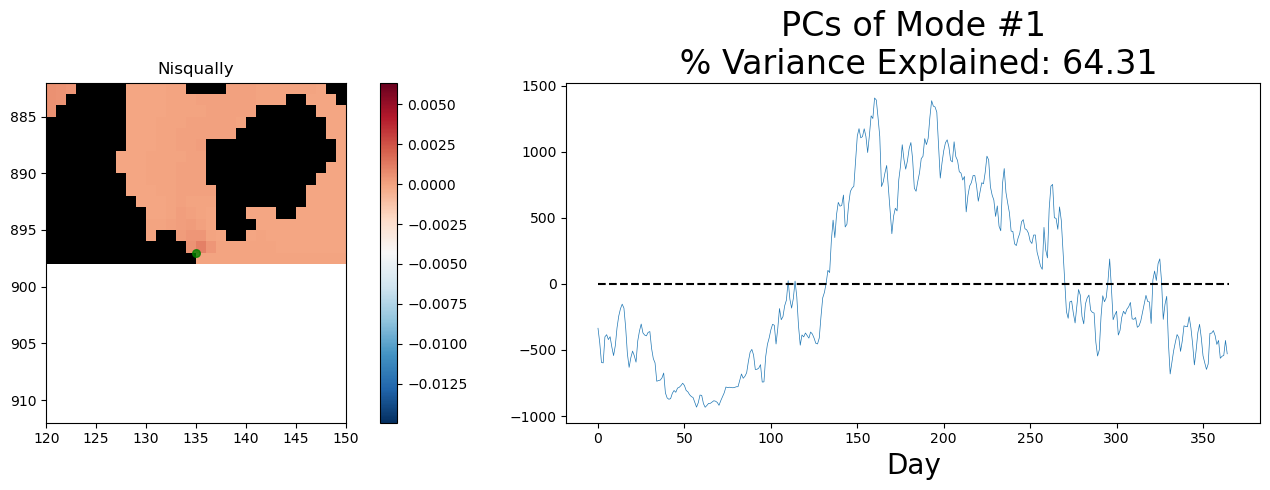

In [8]:
Nisqually_idx = [rivers.prop_dict['puget']['NisquallyMcAllister']['i'], rivers.prop_dict['puget']['NisquallyMcAllister']['j']]
Nisqually_range = [Nisqually_idx[0] - 15, Nisqually_idx[0] + 15, Nisqually_idx[1] - 15, Nisqually_idx[1] + 15]

#plot the first n modes and PCs -- choose a value of 'n' from the variance explained figure
n = 0
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

to_show = np.ma.masked_array(np.flipud(np.reshape(eigvecs[n],(Ny,Nx))), mask=tmask[0])
cb = ax[0].pcolormesh(np.flipud(np.reshape(eigvecs[n],(Ny,Nx))), cmap='RdBu_r')
plt.colorbar(cb)
cb2 = ax[0].pcolormesh(np.flipud(land), cmap='gray')  ################## want
viz_tools.set_aspect(ax[0]);
ax[0].set_xlim(Nisqually_range[2], Nisqually_range[3])
ax[0].set_ylim(Ny-Nisqually_range[0], Ny-Nisqually_range[1])
ax[0].scatter(Nisqually_idx[1], Ny-Nisqually_idx[0], s=30, color='g',alpha=0.8)
ax[0].set_title('Nisqually')


ax[1].plot(PCs[:,n], linewidth = 0.5)
ax[1].plot([0,num_days], [0,0],'k--')
ax[1].set_title('PCs of Mode #' + str(n+1) + "\n % Variance Explained: " + str(round(100*fracVar[n],2)), fontsize = 24)
ax[1].set_xlabel('Day', fontsize = 20)
    
plt.tight_layout()
plt.show()

# max_pc = PCs[:,0].max()

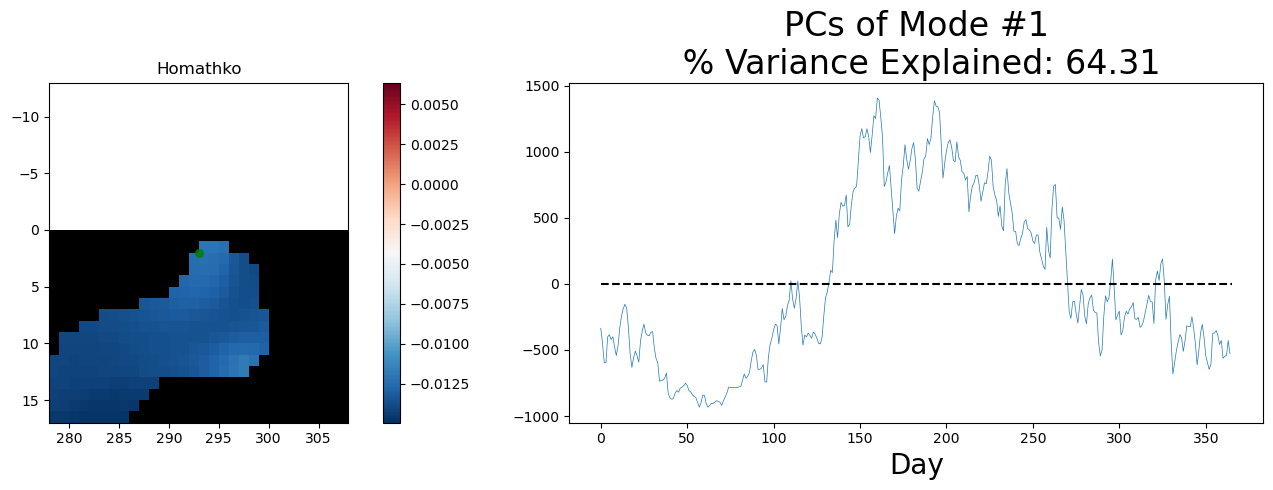

In [9]:
Homathko_idx = [rivers.prop_dict['bute']['Homathko']['i'], rivers.prop_dict['bute']['Homathko']['j']]
Homathko_range = [Homathko_idx[0] - 15, Homathko_idx[0] + 15, Homathko_idx[1] - 15, Homathko_idx[1] + 15]

#plot the first n modes and PCs -- choose a value of 'n' from the variance explained figure
n = 0
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

to_show = np.ma.masked_array(np.flipud(np.reshape(eigvecs[n],(Ny,Nx))), mask=tmask[0])
cb = ax[0].pcolormesh(np.flipud(np.reshape(eigvecs[n],(Ny,Nx))), cmap='RdBu_r')
plt.colorbar(cb)
cb2 = ax[0].pcolormesh(np.flipud(land), cmap='gray')  ################## want
viz_tools.set_aspect(ax[0]);
ax[0].set_xlim(Homathko_range[2], Homathko_range[3])
ax[0].set_ylim(Ny-Homathko_range[0], Ny-Homathko_range[1])
ax[0].scatter(Homathko_idx[1], Ny-Homathko_idx[0], s=30, color='g',alpha=0.8)
ax[0].set_title('Homathko')


ax[1].plot(PCs[:,n], linewidth = 0.5)
ax[1].plot([0,num_days], [0,0],'k--')
ax[1].set_title('PCs of Mode #' + str(n+1) + "\n % Variance Explained: " + str(round(100*fracVar[n],2)), fontsize = 24)
ax[1].set_xlabel('Day', fontsize = 20)
    
plt.tight_layout()
plt.show()

# max_pc = PCs[:,0].max()

In [10]:
def river_zoom(w_shed, r_call, r_name, n):
    river_idx = [rivers.prop_dict[w_shed][r_call]['i'], rivers.prop_dict[w_shed][r_call]['j']]
    river_range = [river_idx[0] - 15, river_idx[0] + 15, river_idx[1] - 15, river_idx[1] + 15]

    if (river_range[0] < 0):
        river_range[0] = 0
        river_range[1] = 30

    if (898 - river_range[1] < 0):
        river_range[0] = 898-30
        river_range[1] = 898

    #plot the first n modes and PCs -- choose a value of 'n' from the variance explained figure
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    to_show = np.ma.masked_array(np.flipud(np.reshape(eigvecs[n],(Ny,Nx))), mask=tmask[0])
    cb = ax[0].pcolormesh(np.flipud(np.reshape(eigvecs[n],(Ny,Nx))), cmap='RdBu_r',vmin=-0.014,vmax=0.014)
    plt.colorbar(cb)
    cb2 = ax[0].pcolormesh(np.flipud(land), cmap='gray')  ################## want
    viz_tools.set_aspect(ax[0]);
    ax[0].set_xlim(river_range[2], river_range[3])
    ax[0].set_ylim(Ny-river_range[0], Ny-river_range[1])
    ax[0].scatter(river_idx[1], Ny-river_idx[0], s=30, color='g',alpha=0.8)
    ax[0].set_title(r_name + '\n PC strength: ' + str(PCs[:,n].max()/1500))


    ax[1].plot(PCs[:,n]/max_pc, linewidth = 0.5)
    ax[1].plot([0,num_days], [0,0],'k--',linewidth = 0.5)
    ax[1].set_title('PCs of Mode #' + str(n+1) + "\n % Variance Explained: " + str(round(100*fracVar[n],2)), fontsize = 24)
    ax[1].set_xlabel('Day', fontsize = 20)
    ax[1].set_ylim([-1,1.05])
    ax[1].set_xlim([0,num_days])
        
    plt.tight_layout()
    plt.show()

## Homathko

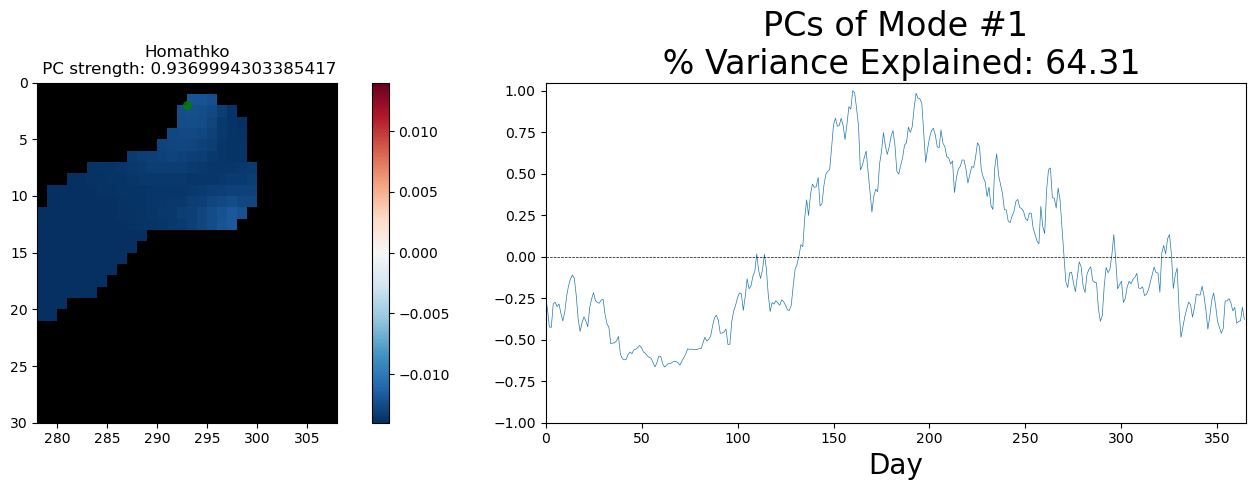

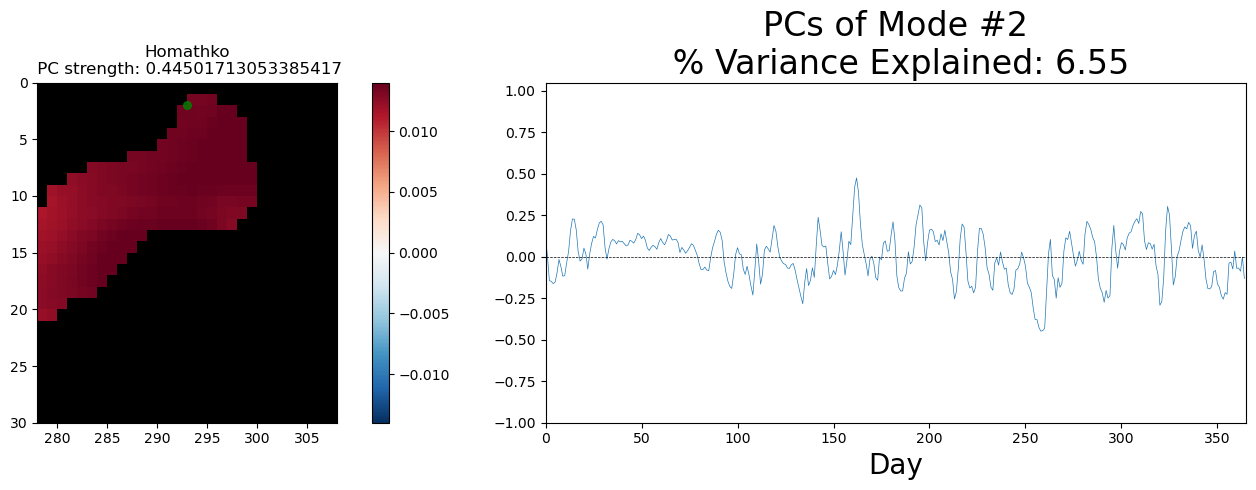

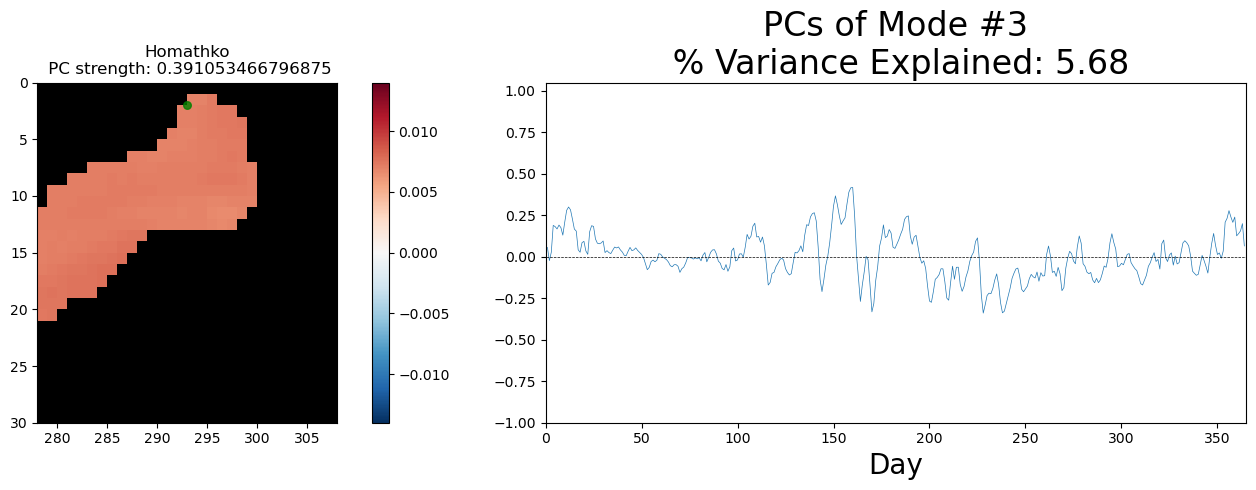

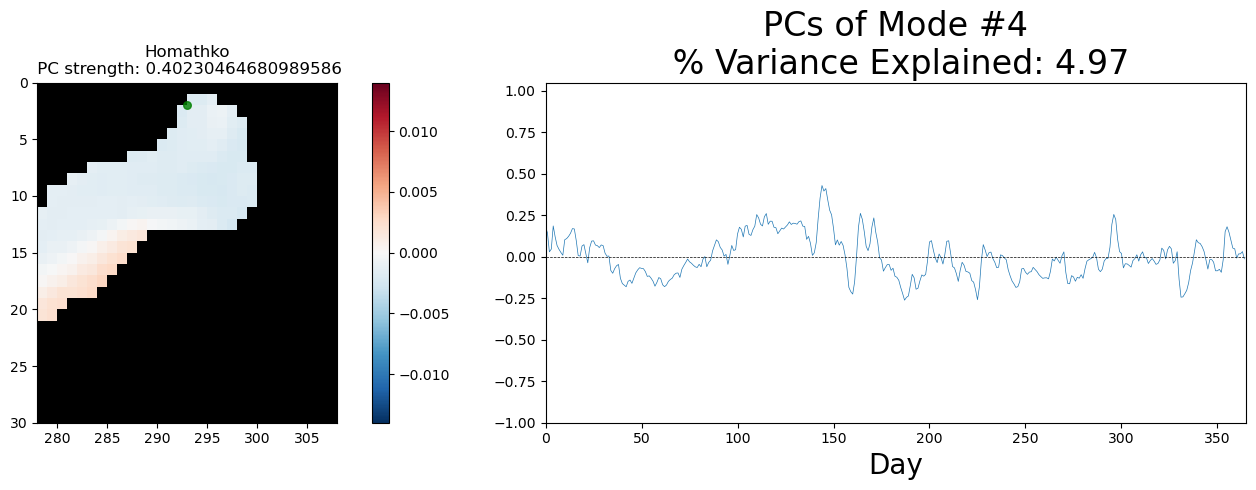

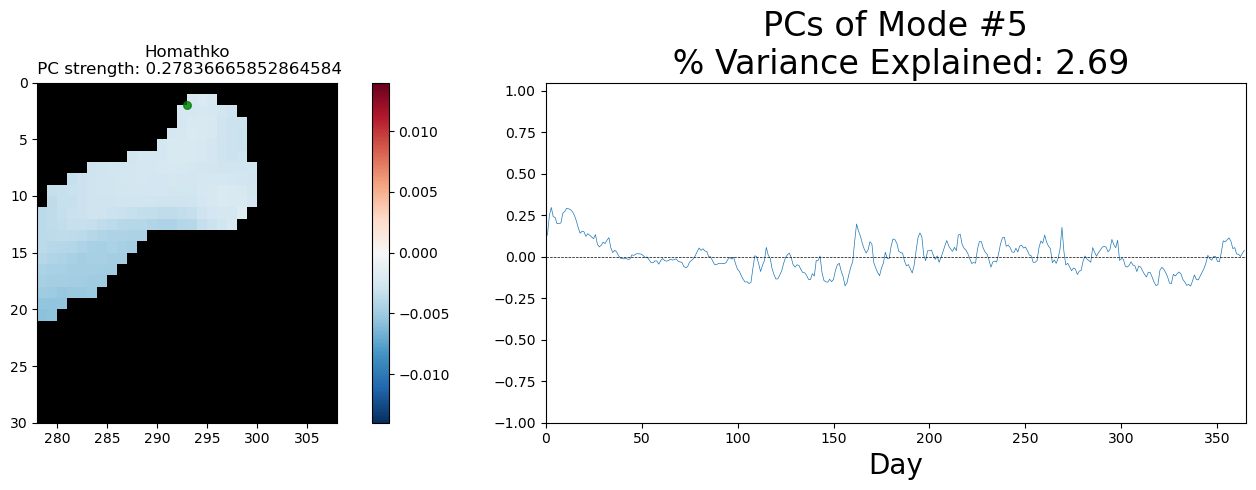

In [11]:
river_zoom('bute','Homathko','Homathko',0)
river_zoom('bute','Homathko','Homathko',1)
river_zoom('bute','Homathko','Homathko',2)
river_zoom('bute','Homathko','Homathko',3)
river_zoom('bute','Homathko','Homathko',4)

## Salmon

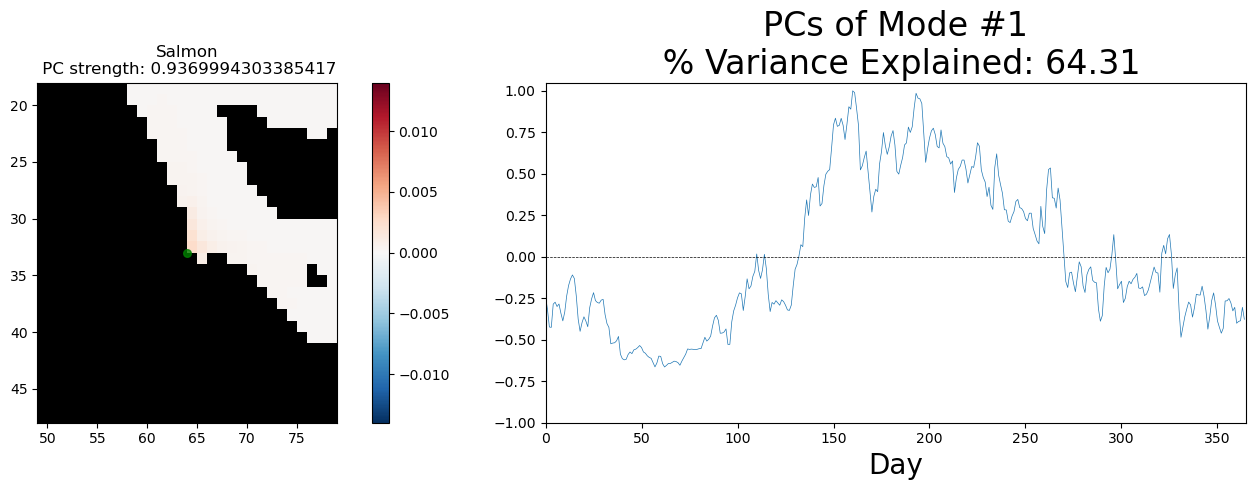

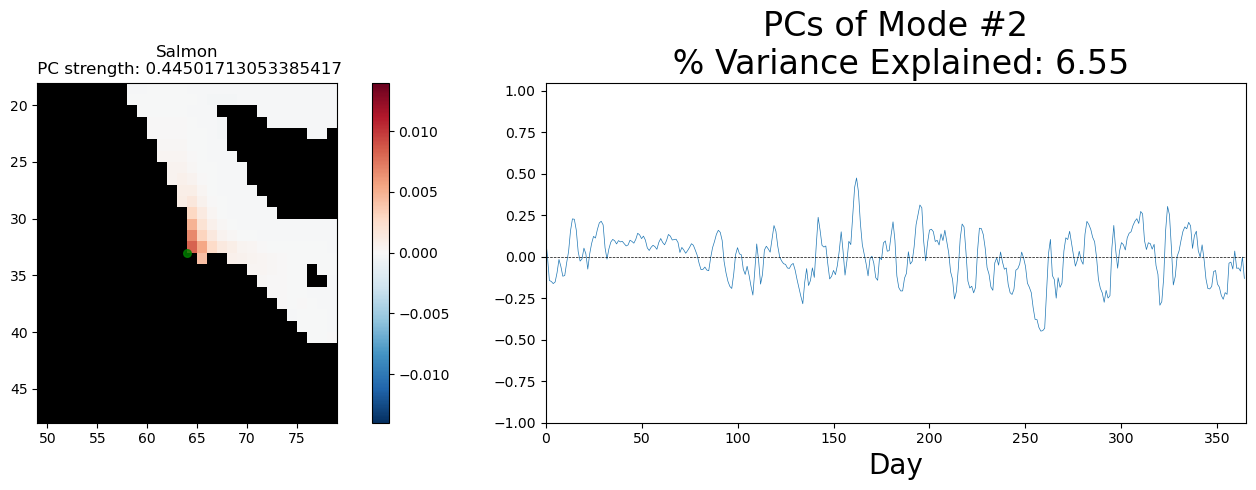

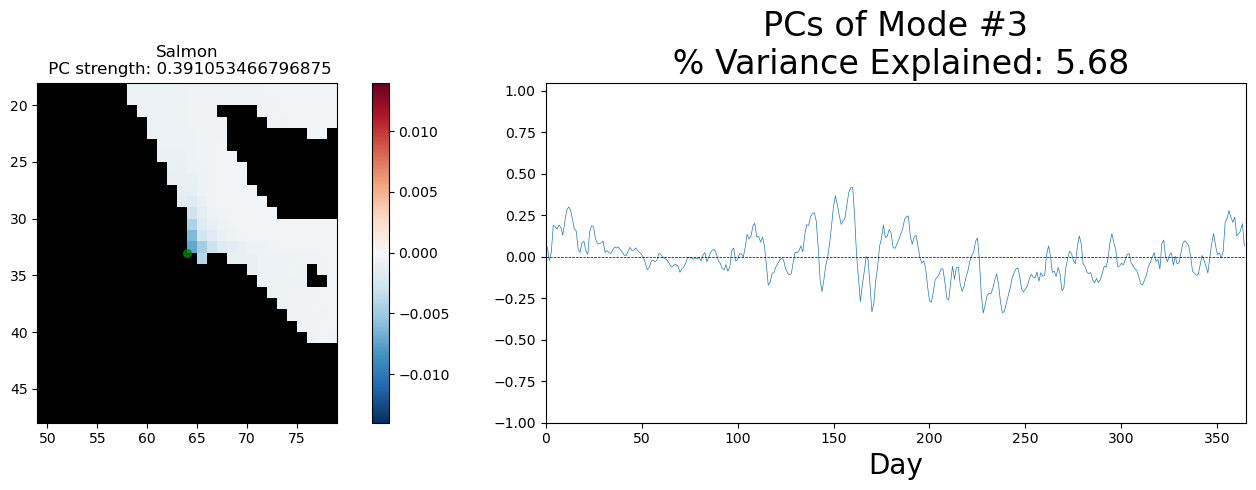

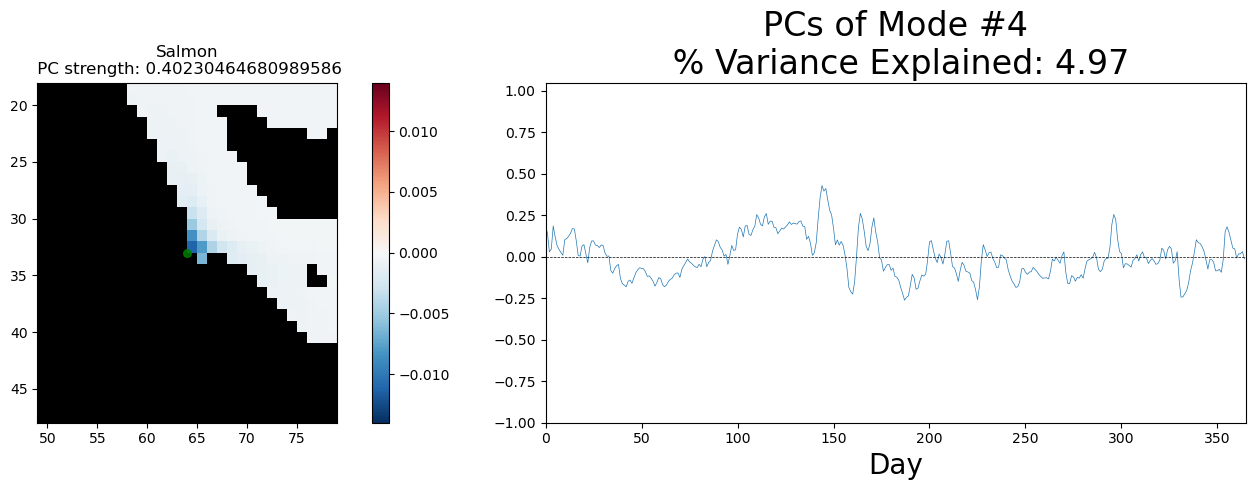

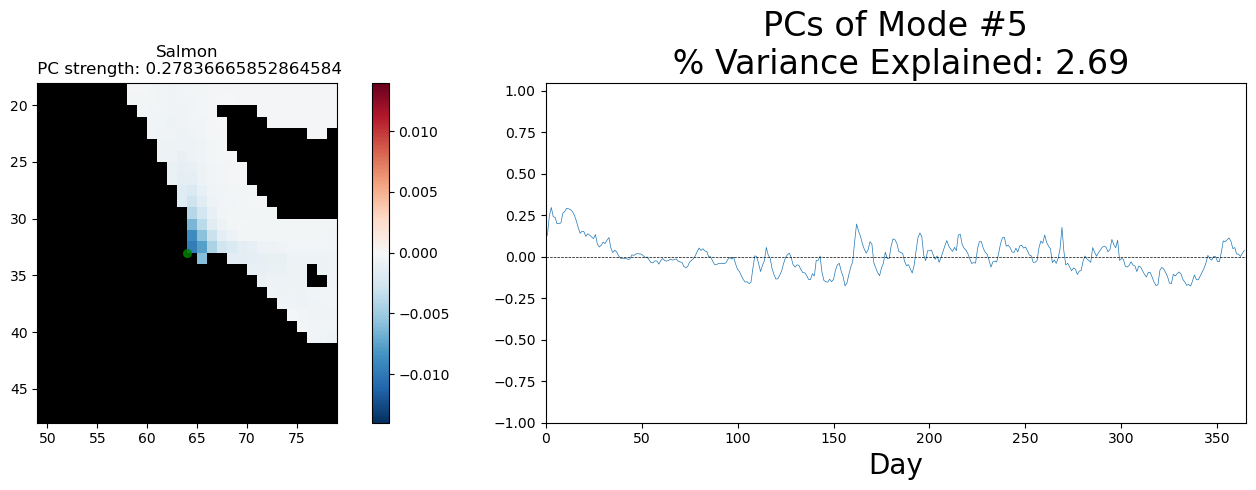

In [12]:
river_zoom('evi_n','SalmonSayward','Salmon',0)
river_zoom('evi_n','SalmonSayward','Salmon',1)
river_zoom('evi_n','SalmonSayward','Salmon',2)
river_zoom('evi_n','SalmonSayward','Salmon',3)
river_zoom('evi_n','SalmonSayward','Salmon',4)

## Cowichan

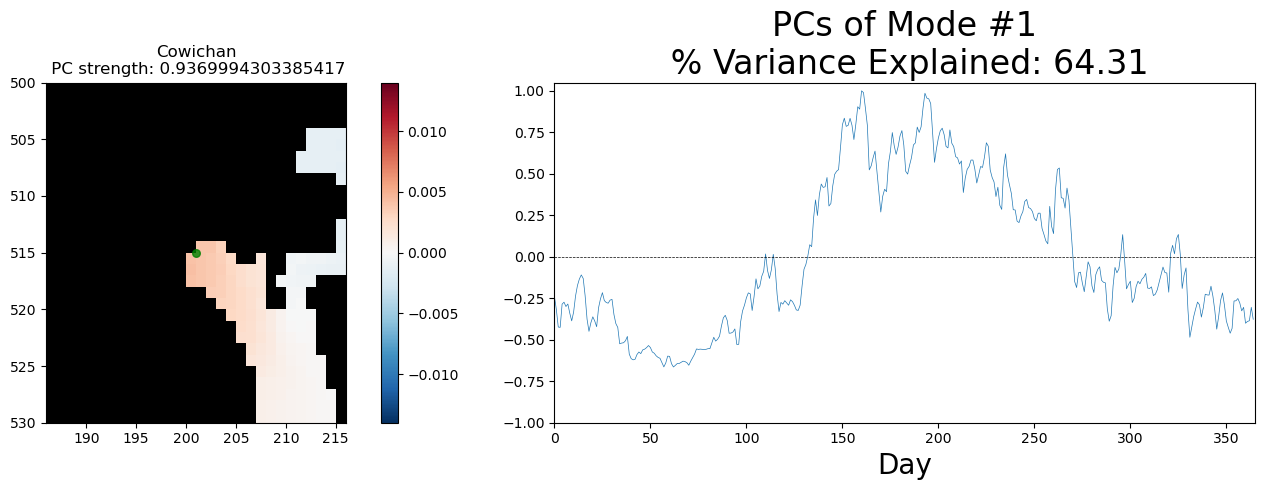

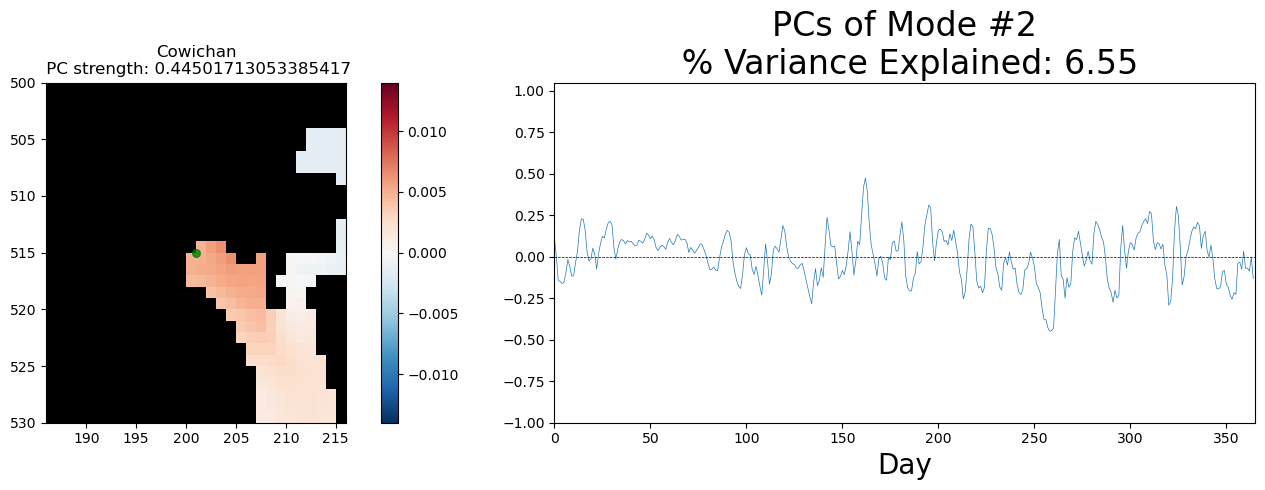

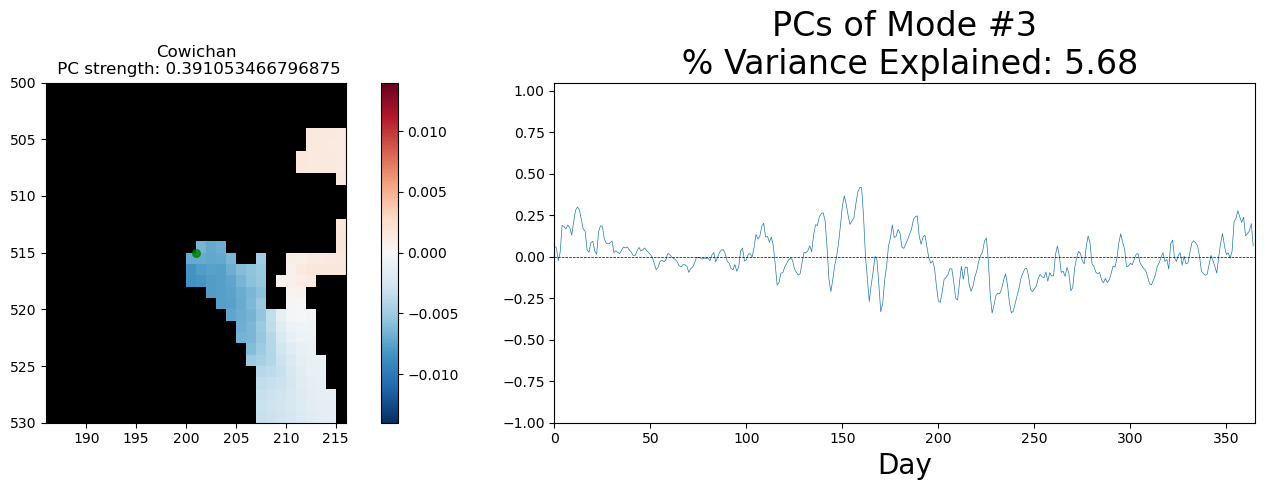

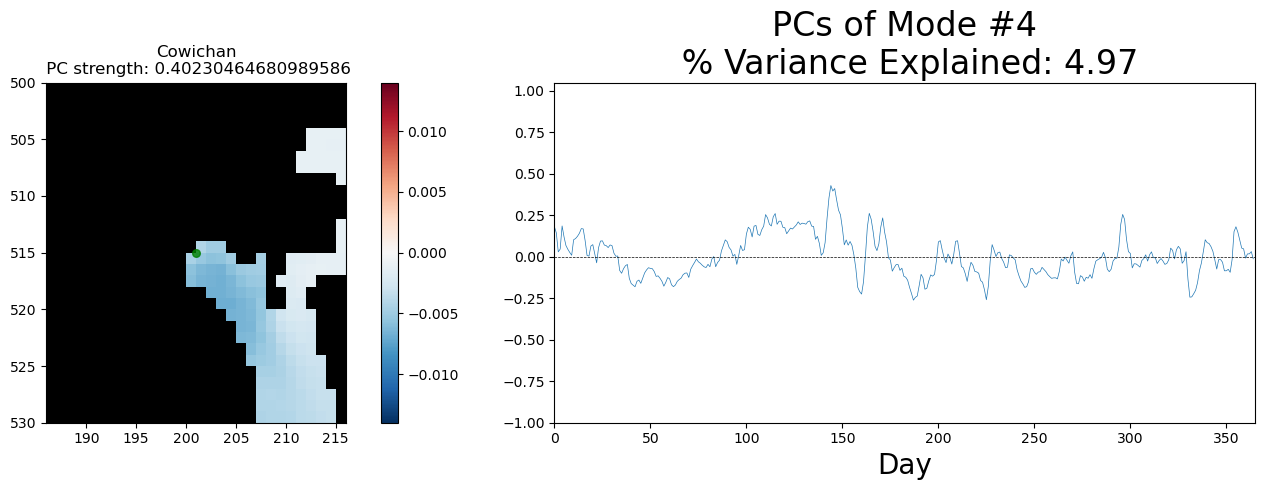

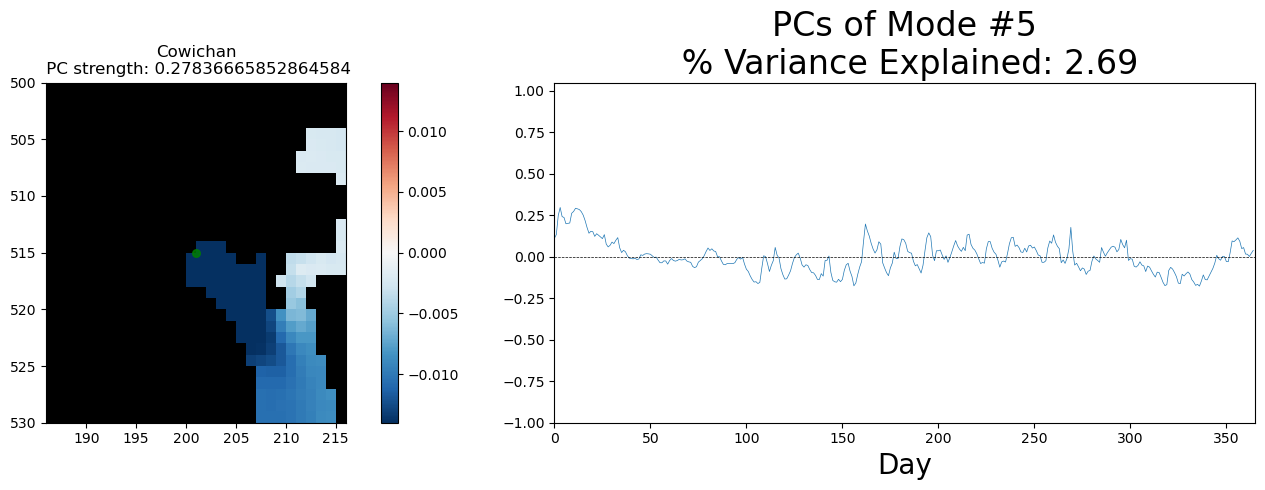

In [13]:
river_zoom('evi_s','Cowichan1','Cowichan',0)
river_zoom('evi_s','Cowichan1','Cowichan',1)
river_zoom('evi_s','Cowichan1','Cowichan',2)
river_zoom('evi_s','Cowichan1','Cowichan',3)
river_zoom('evi_s','Cowichan1','Cowichan',4)

## Nooksack

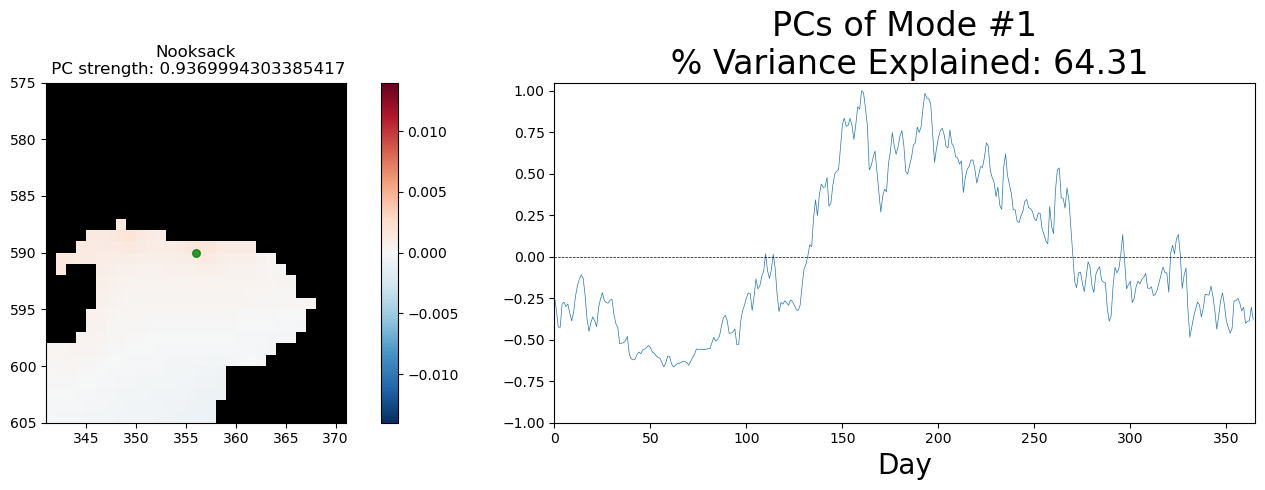

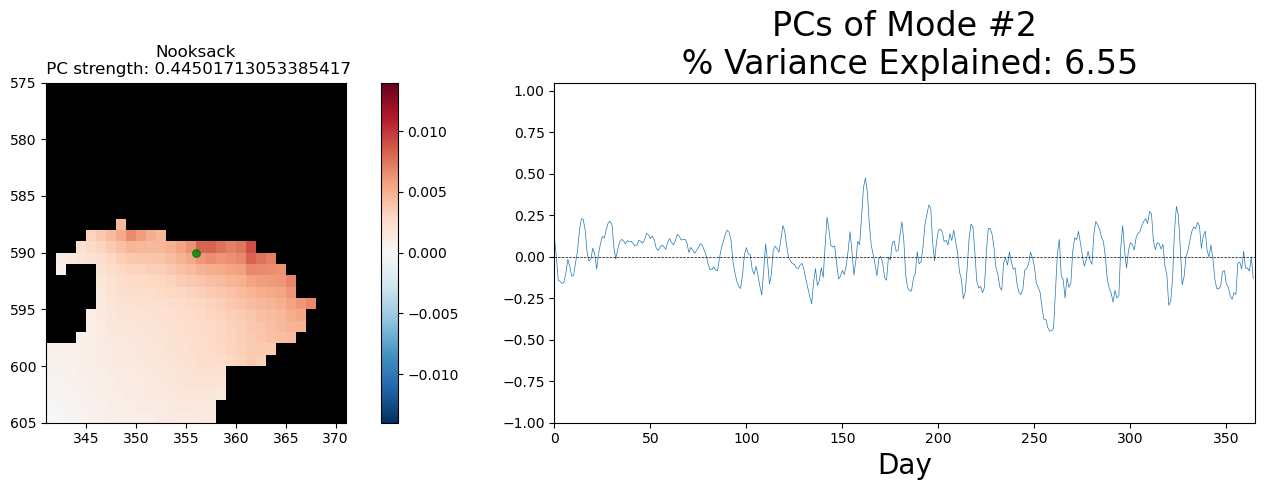

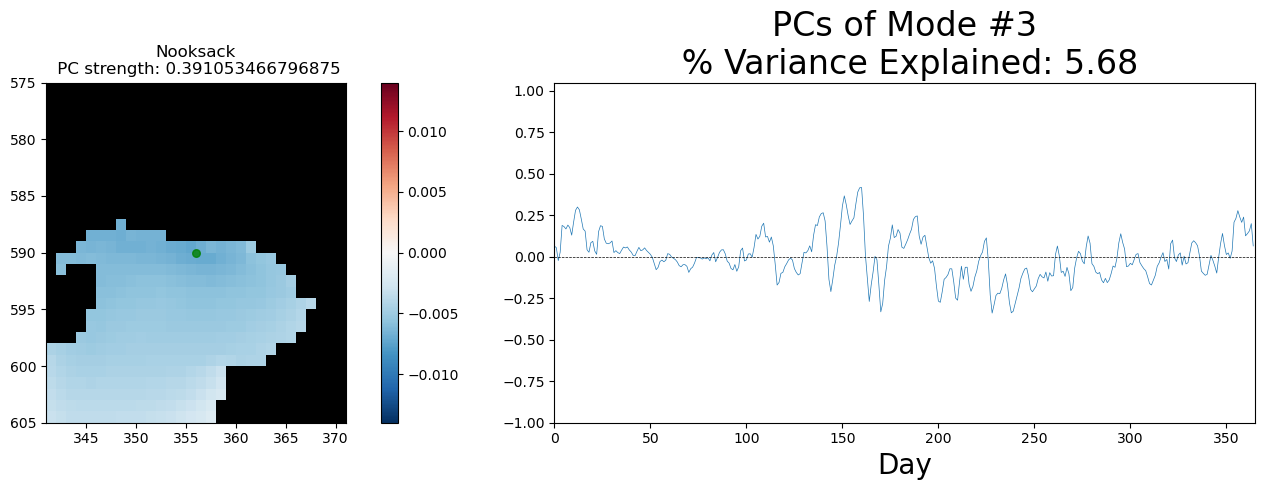

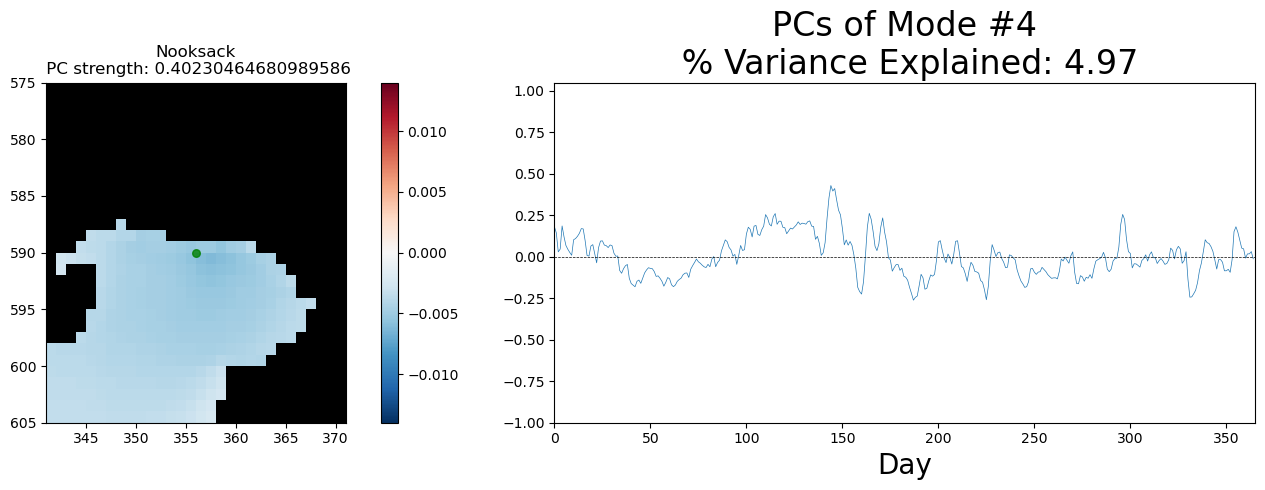

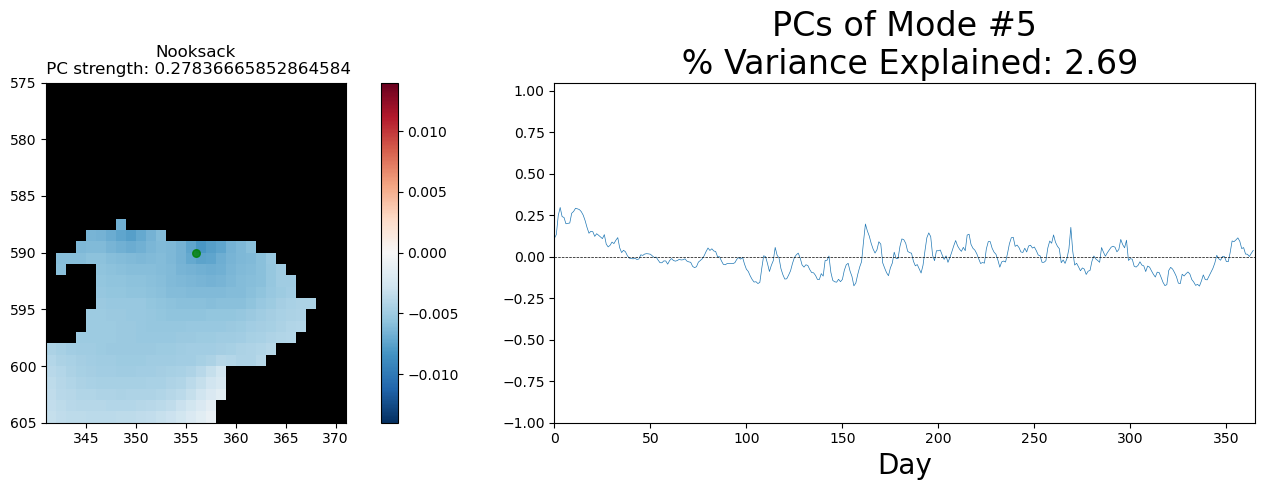

In [14]:
river_zoom('fraser','Nooksack','Nooksack',0)
river_zoom('fraser','Nooksack','Nooksack',1)
river_zoom('fraser','Nooksack','Nooksack',2)
river_zoom('fraser','Nooksack','Nooksack',3)
river_zoom('fraser','Nooksack','Nooksack',4)

## Squamish

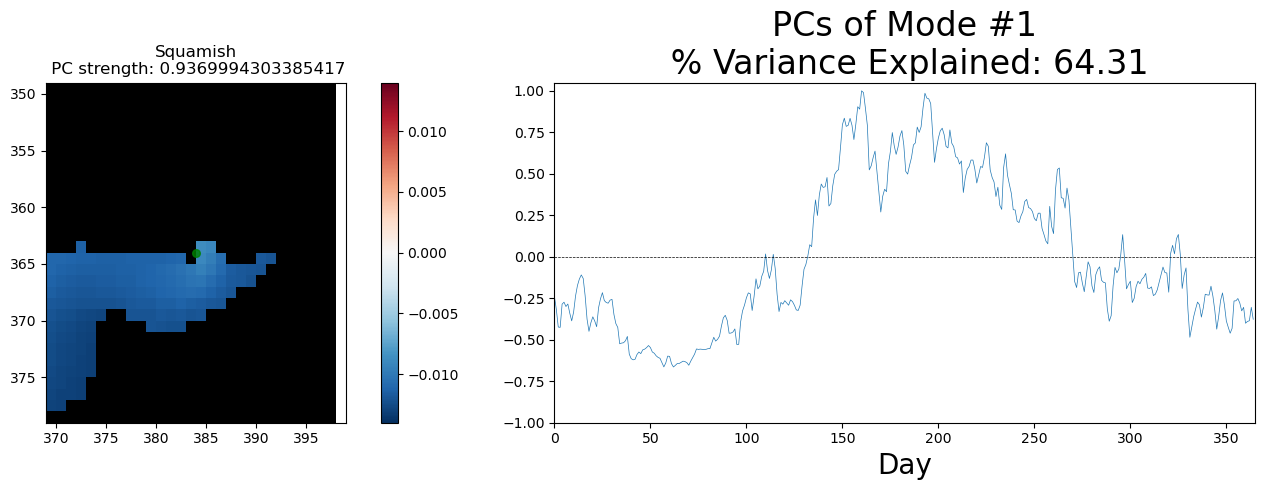

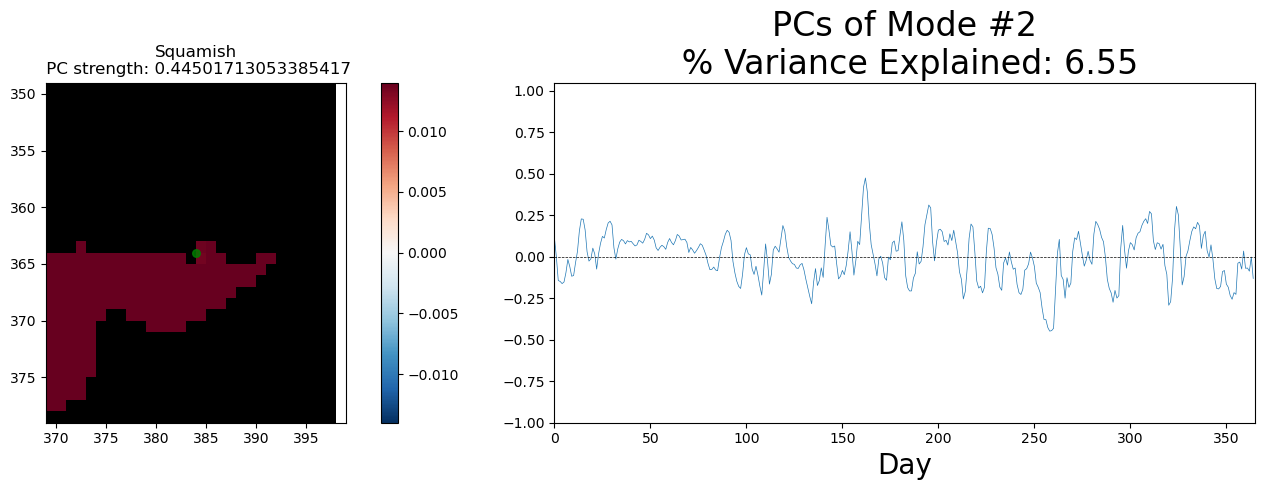

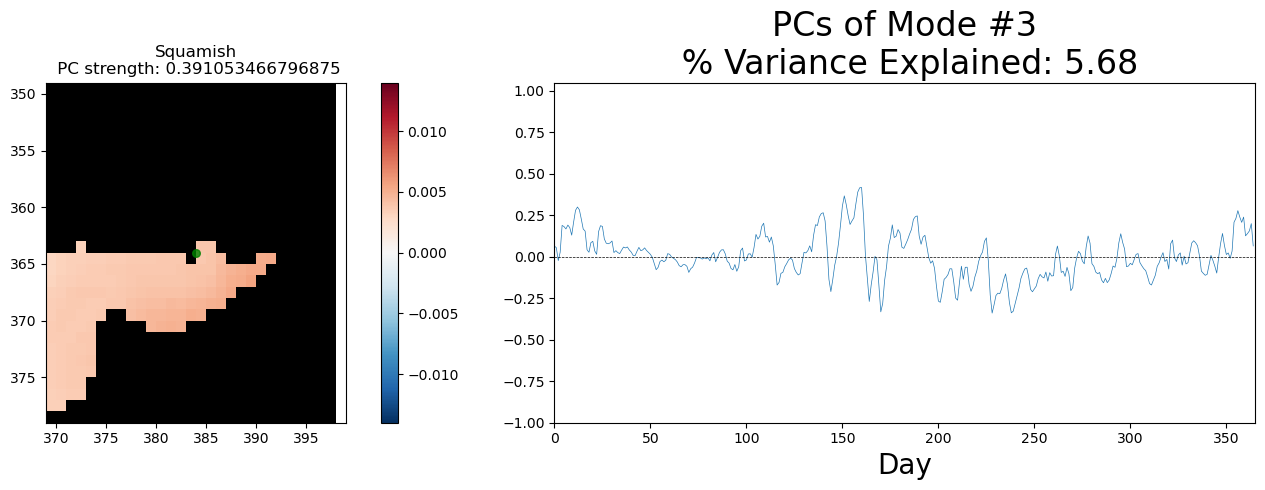

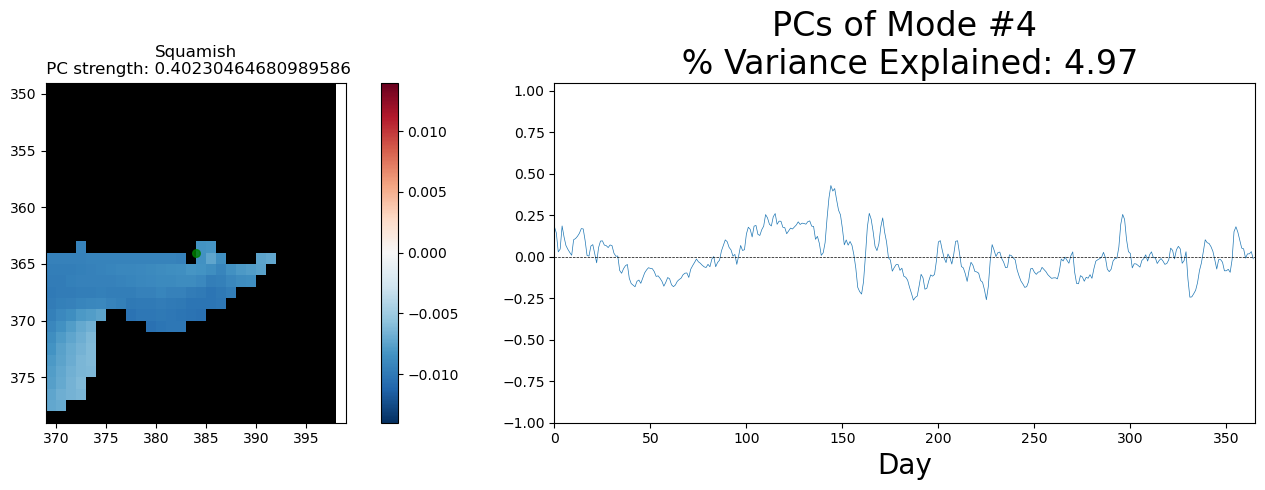

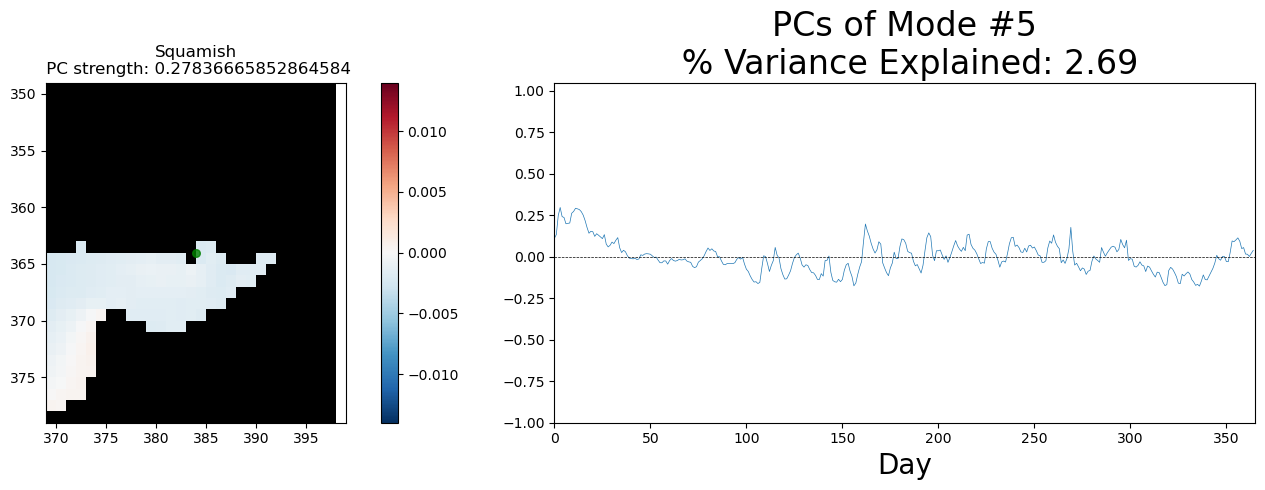

In [15]:
river_zoom('howe','Squamish','Squamish',0)
river_zoom('howe','Squamish','Squamish',1)
river_zoom('howe','Squamish','Squamish',2)
river_zoom('howe','Squamish','Squamish',3)
river_zoom('howe','Squamish','Squamish',4)

## Elwha

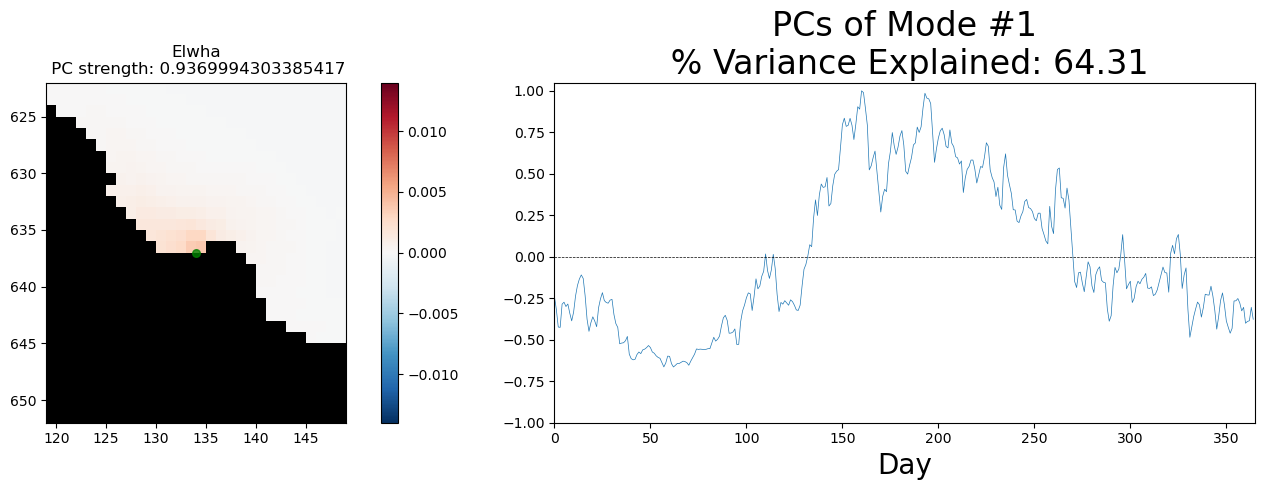

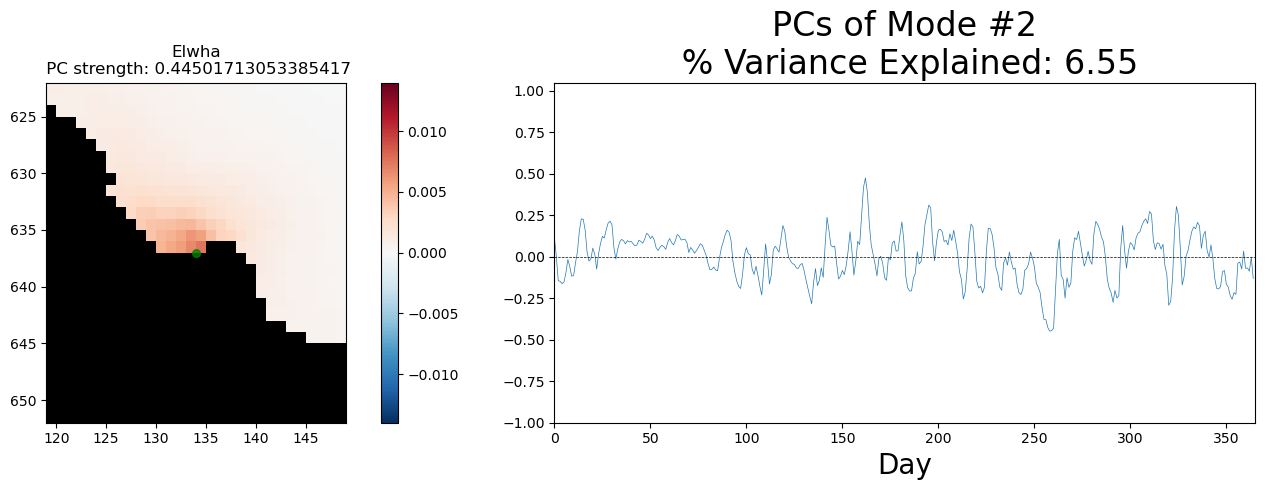

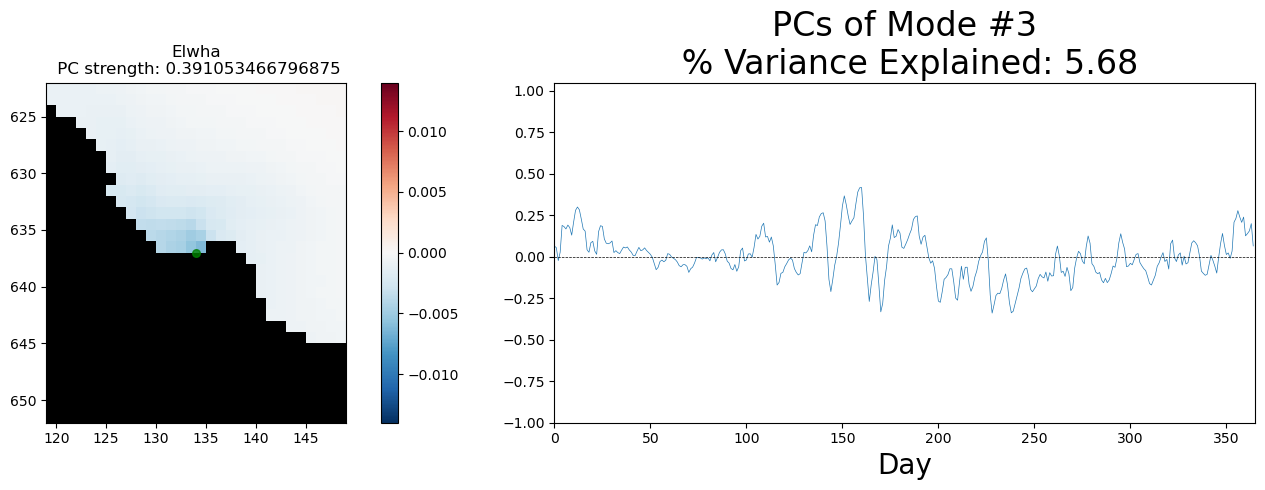

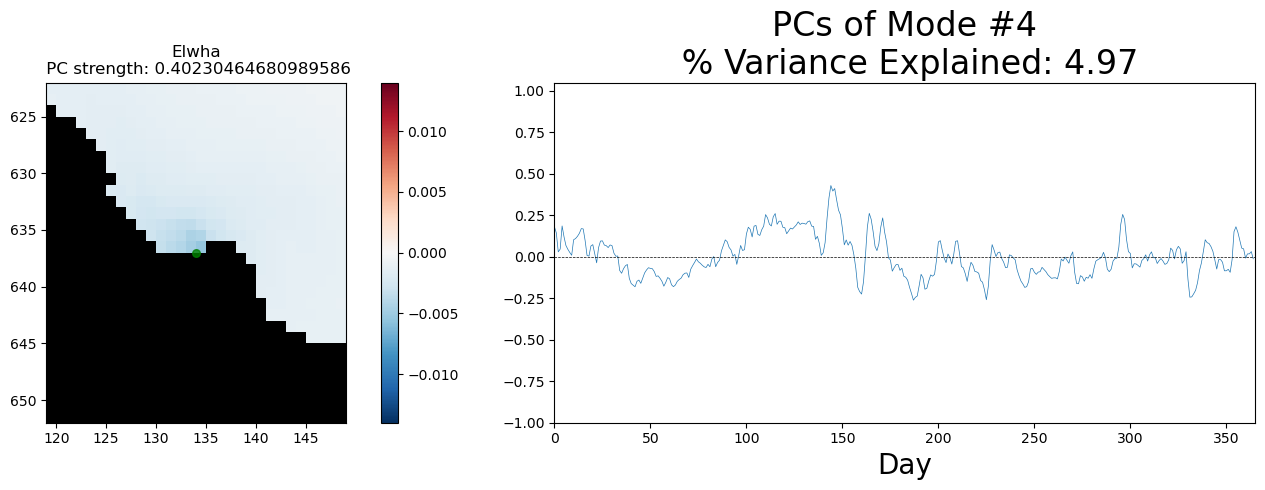

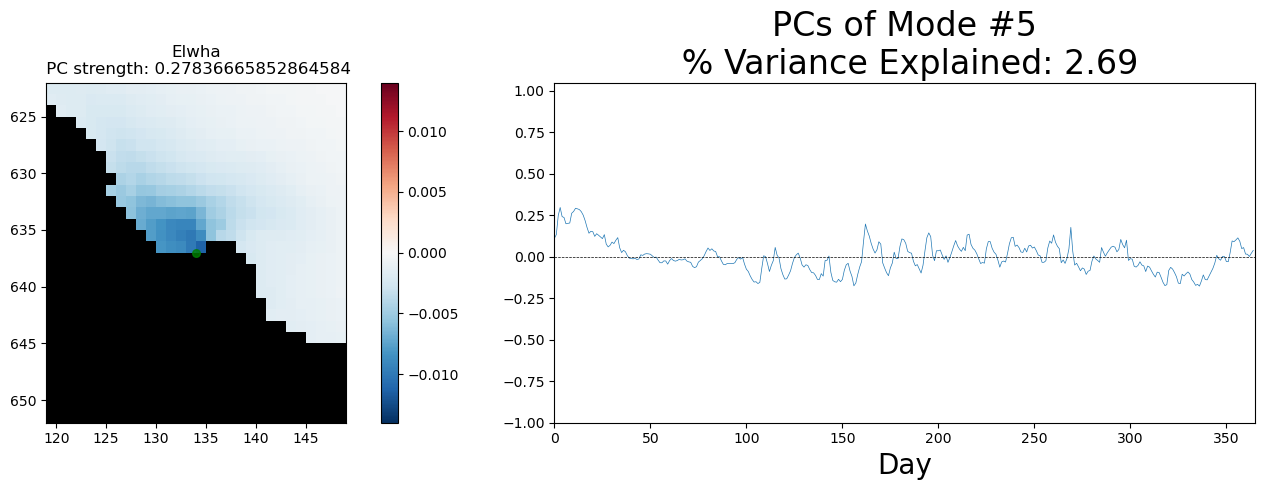

In [16]:
river_zoom('jdf','Elwha','Elwha',0)
river_zoom('jdf','Elwha','Elwha',1)
river_zoom('jdf','Elwha','Elwha',2)
river_zoom('jdf','Elwha','Elwha',3)
river_zoom('jdf','Elwha','Elwha',4)

## Nisqually

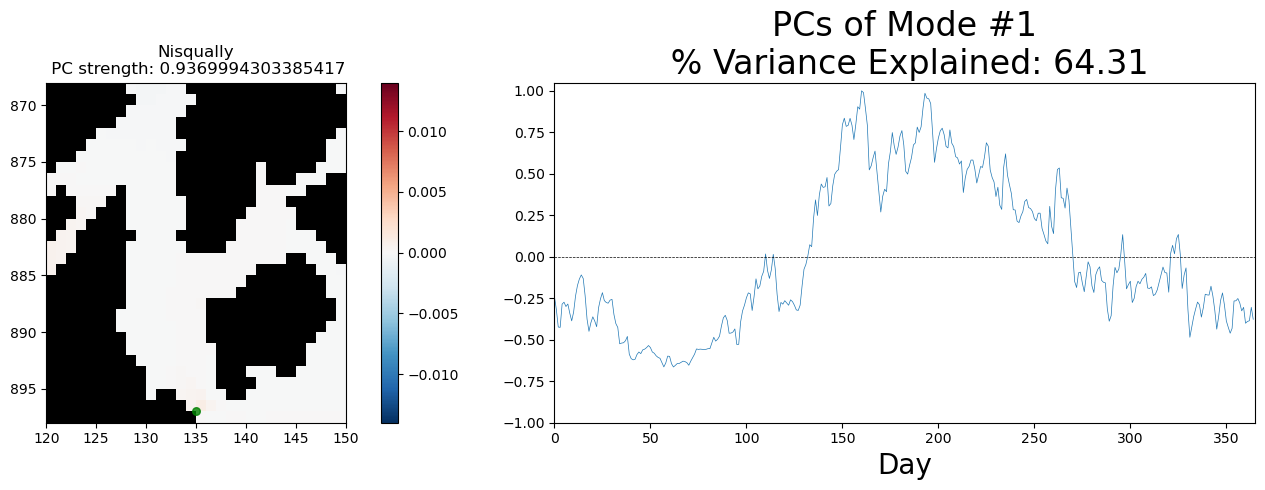

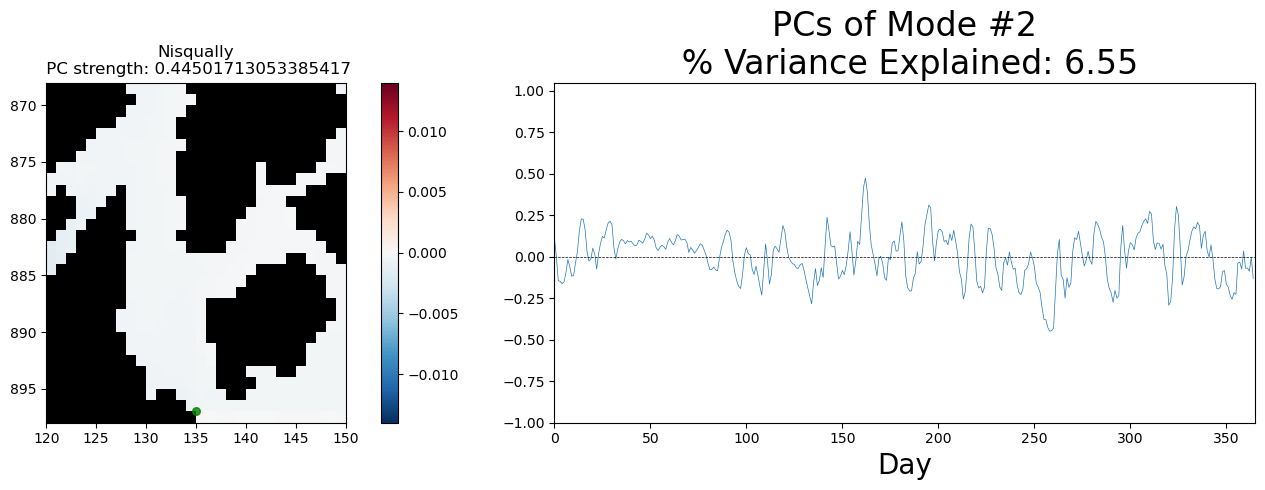

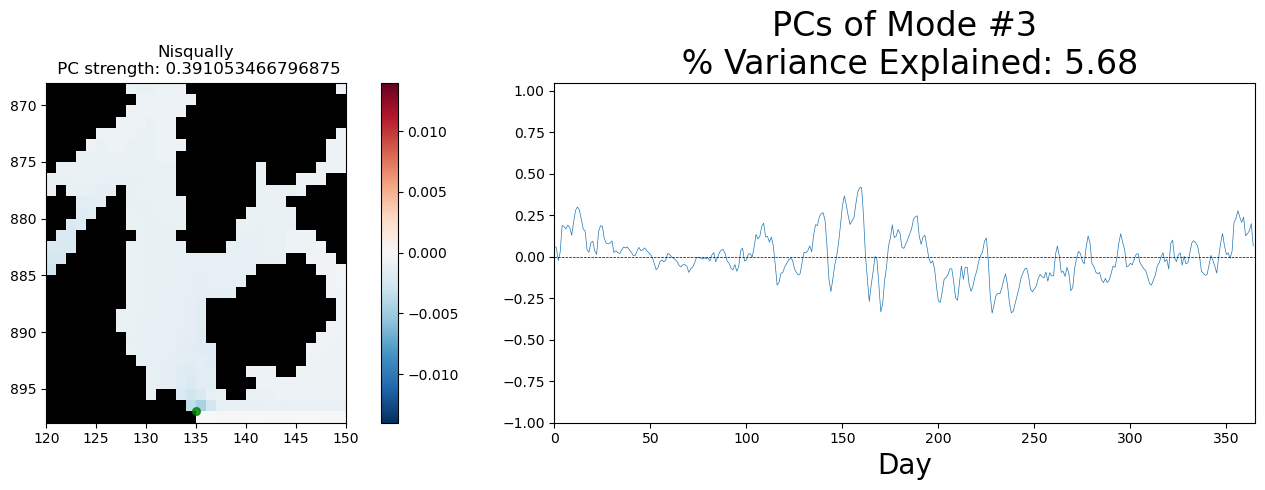

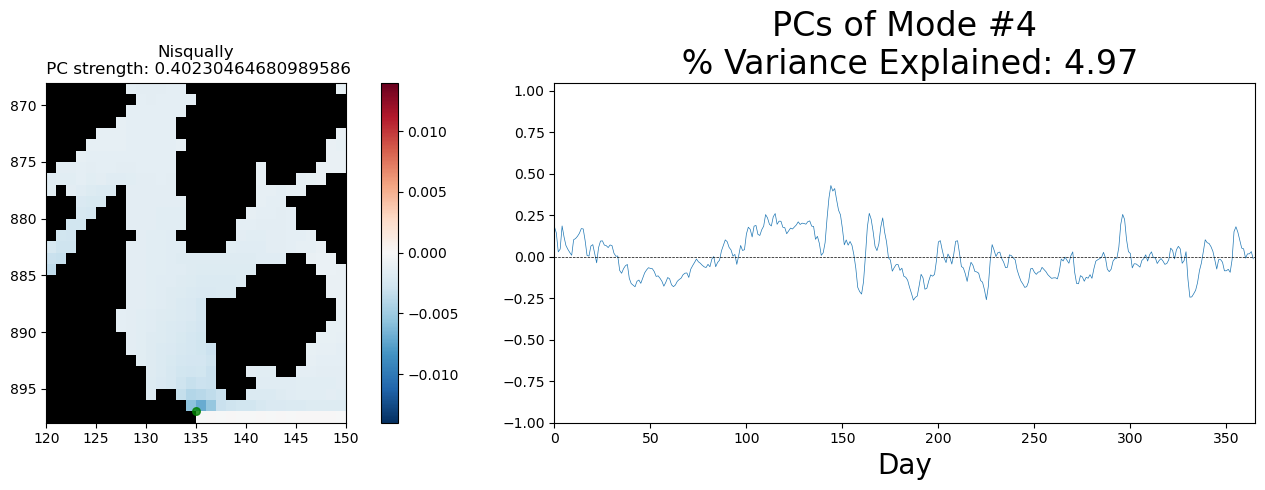

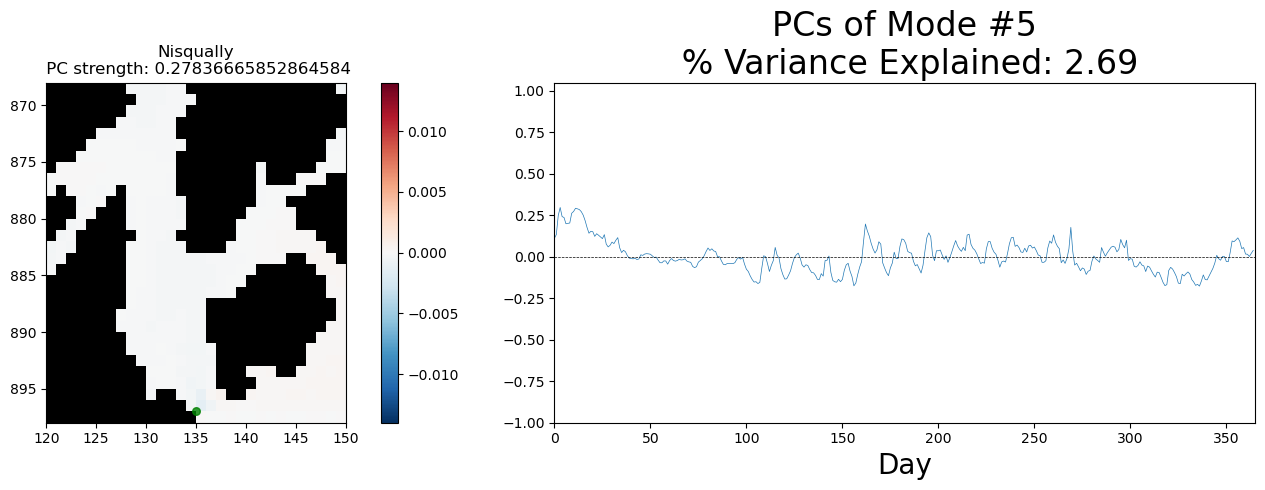

In [17]:
river_zoom('puget','NisquallyMcAllister','Nisqually',0)
river_zoom('puget','NisquallyMcAllister','Nisqually',1)
river_zoom('puget','NisquallyMcAllister','Nisqually',2)
river_zoom('puget','NisquallyMcAllister','Nisqually',3) ##*
river_zoom('puget','NisquallyMcAllister','Nisqually',4)

## Puyallup

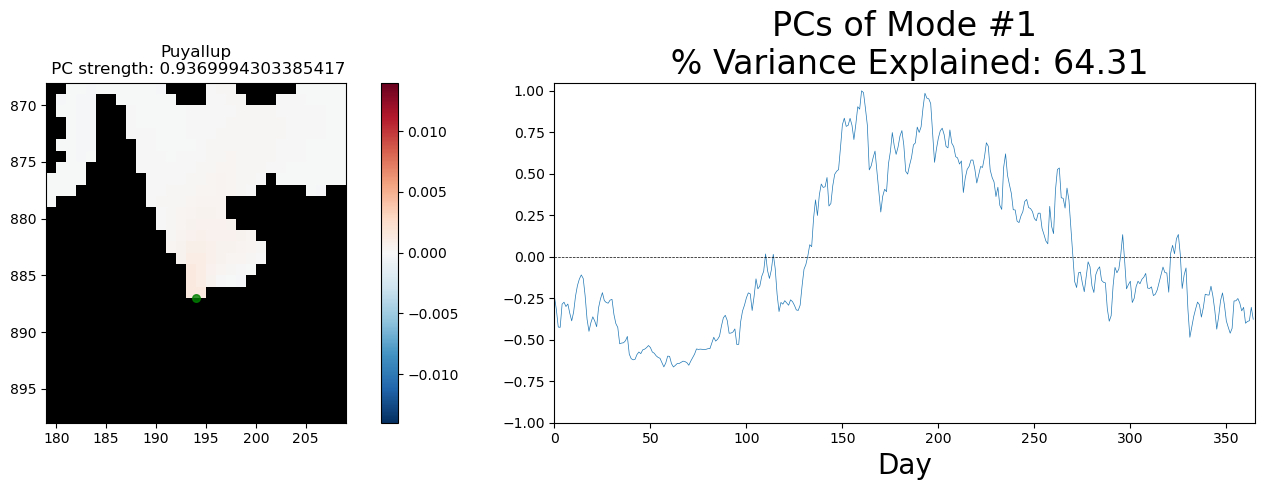

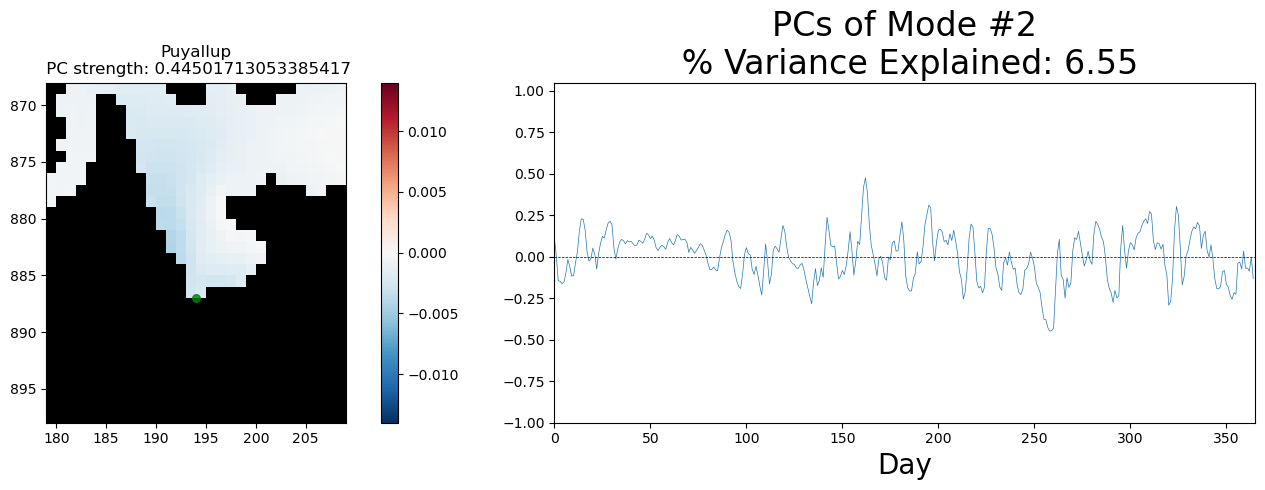

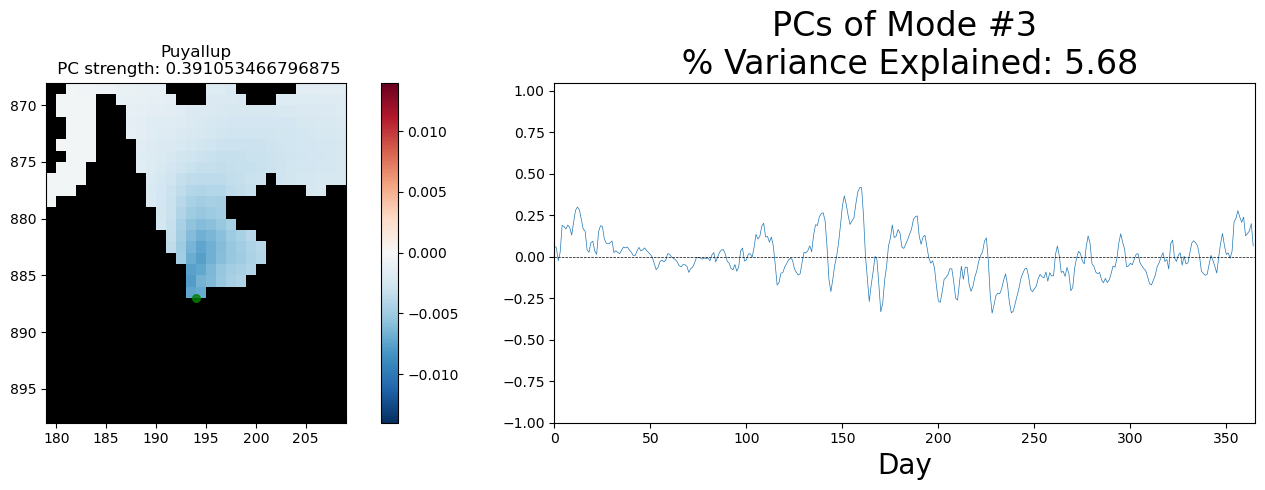

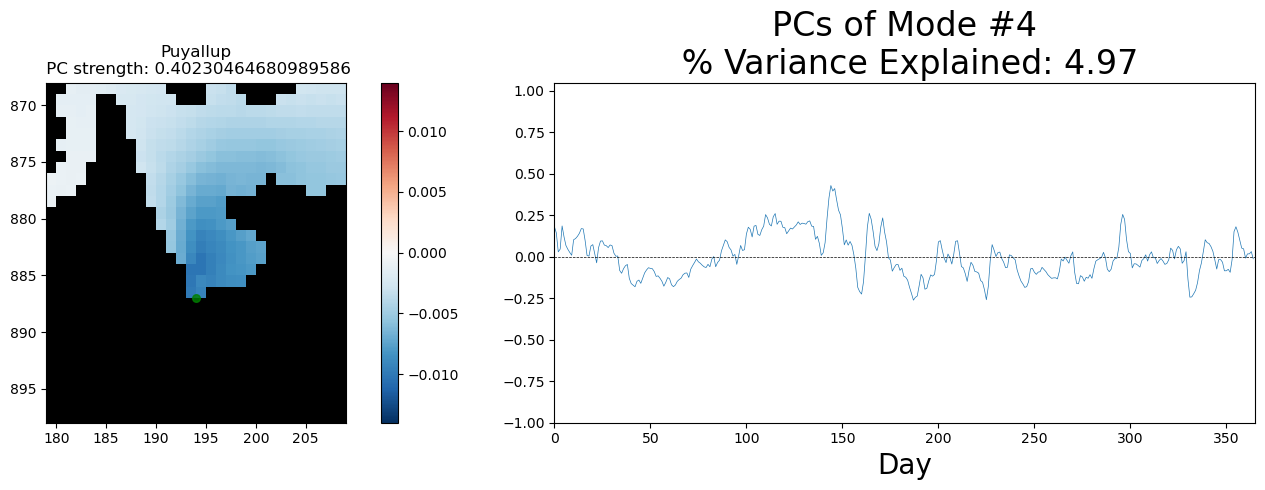

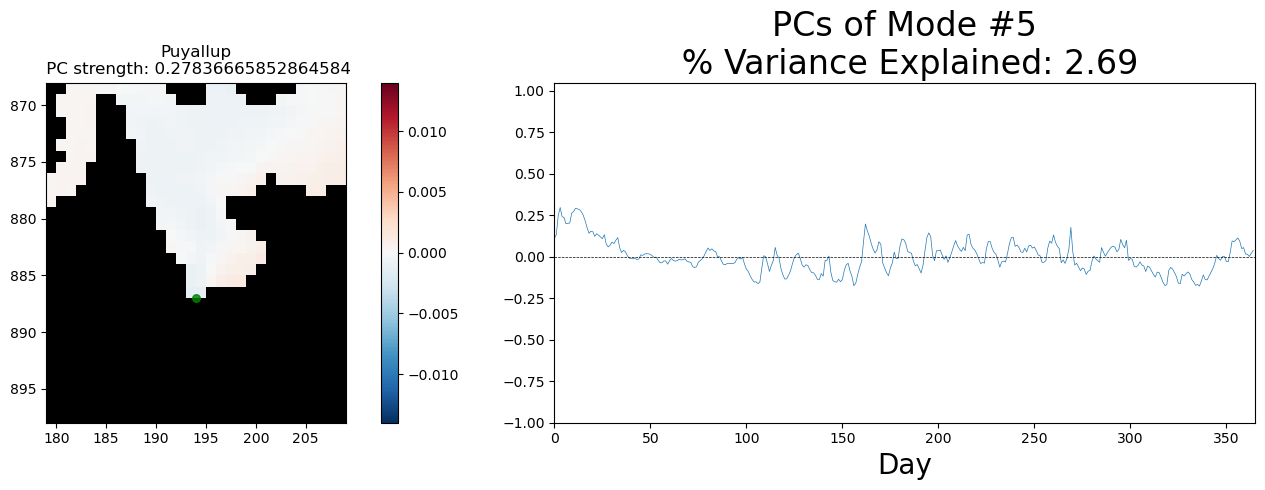

In [18]:
river_zoom('puget','Puyallup','Puyallup',0)
river_zoom('puget','Puyallup','Puyallup',1)
river_zoom('puget','Puyallup','Puyallup',2)
river_zoom('puget','Puyallup','Puyallup',3)
river_zoom('puget','Puyallup','Puyallup',4)

## Stillaguamish

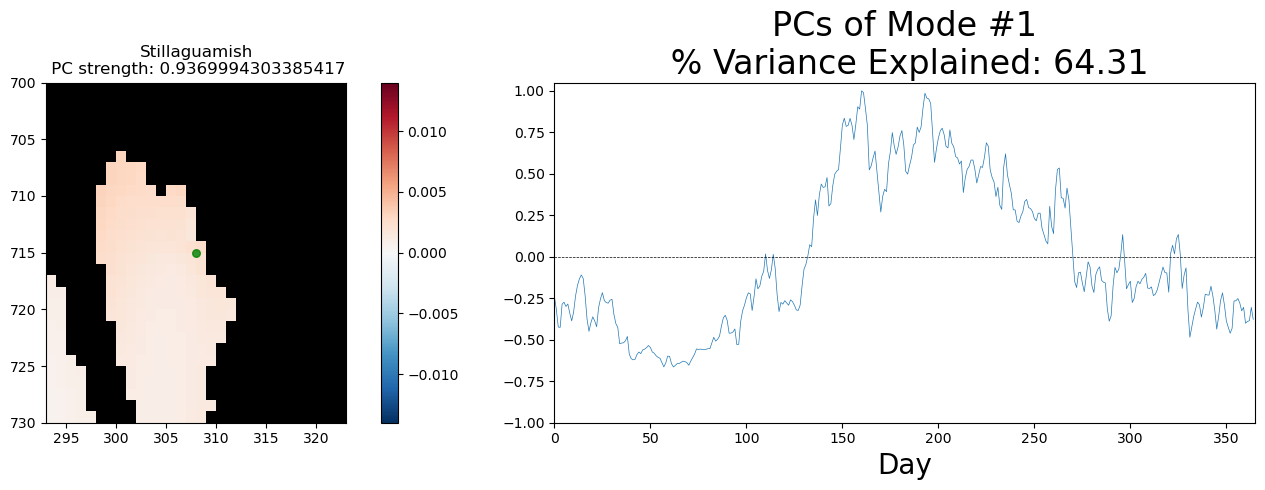

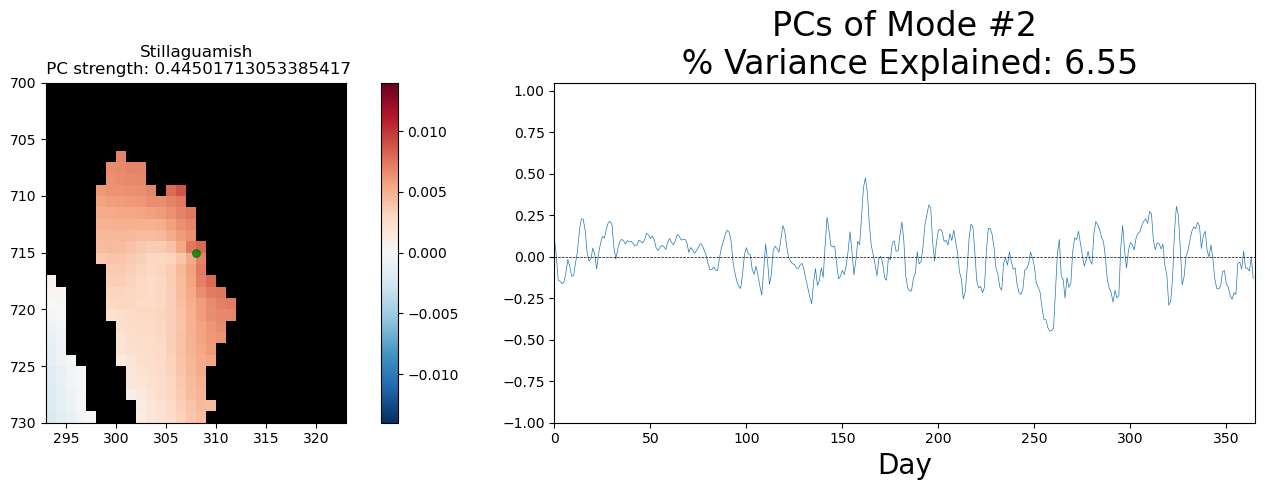

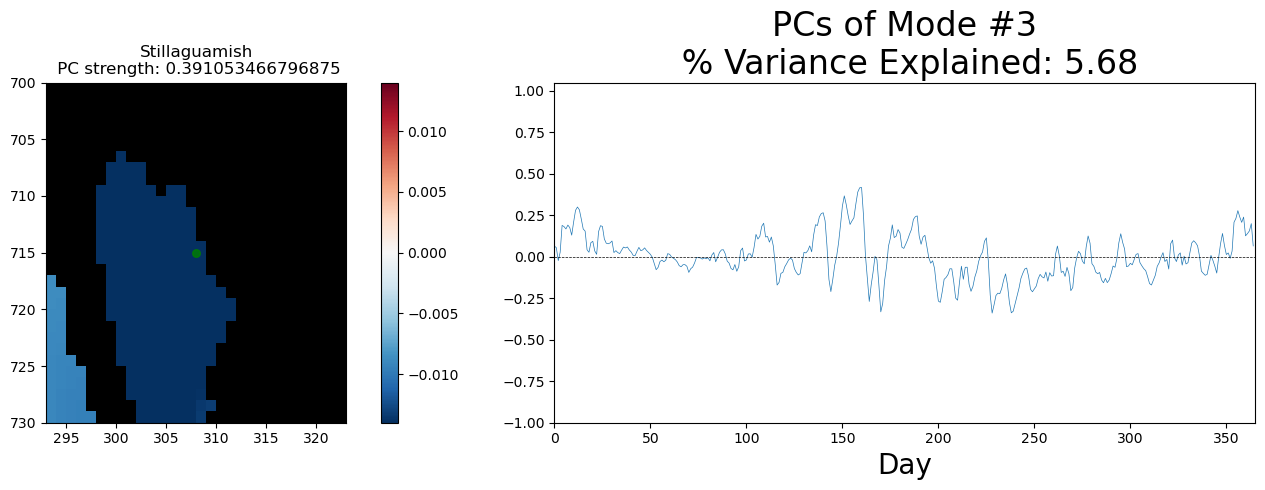

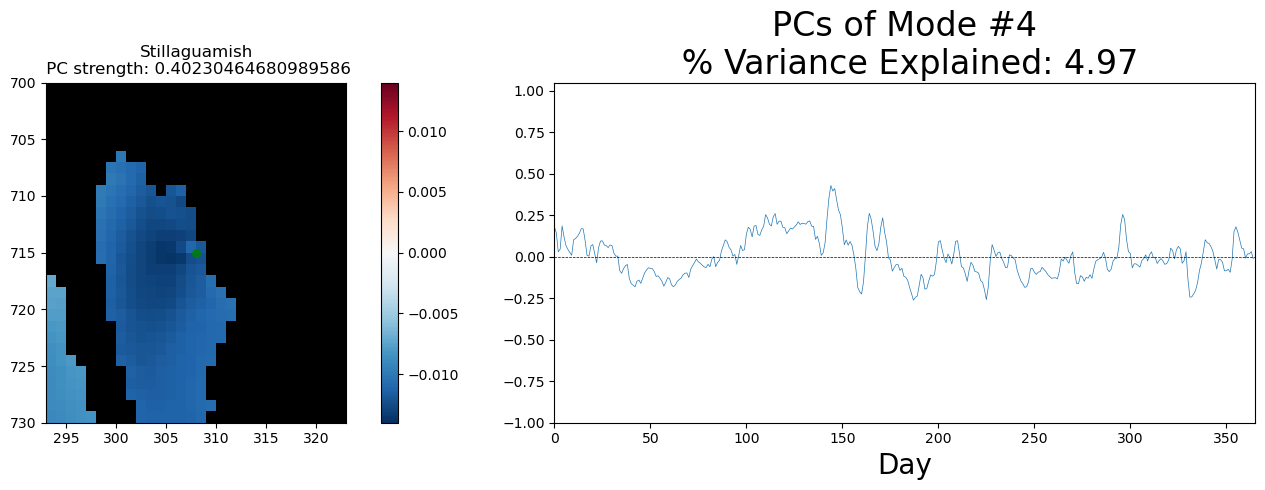

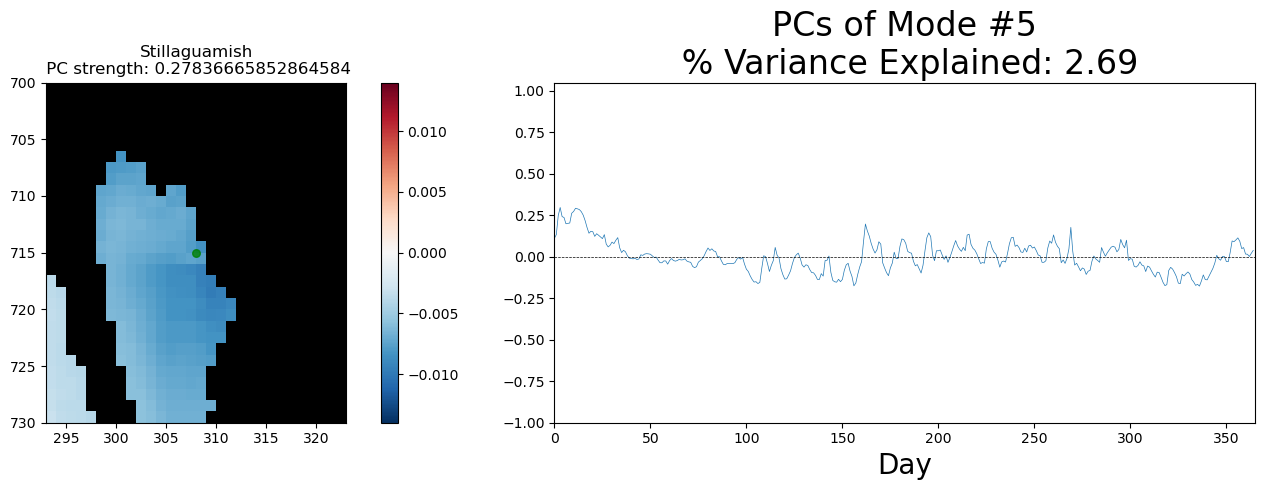

In [19]:
river_zoom('skagit','Stillaguamish1','Stillaguamish',0)
river_zoom('skagit','Stillaguamish1','Stillaguamish',1)
river_zoom('skagit','Stillaguamish1','Stillaguamish',2)
river_zoom('skagit','Stillaguamish1','Stillaguamish',3)
river_zoom('skagit','Stillaguamish1','Stillaguamish',4)

## Skagit

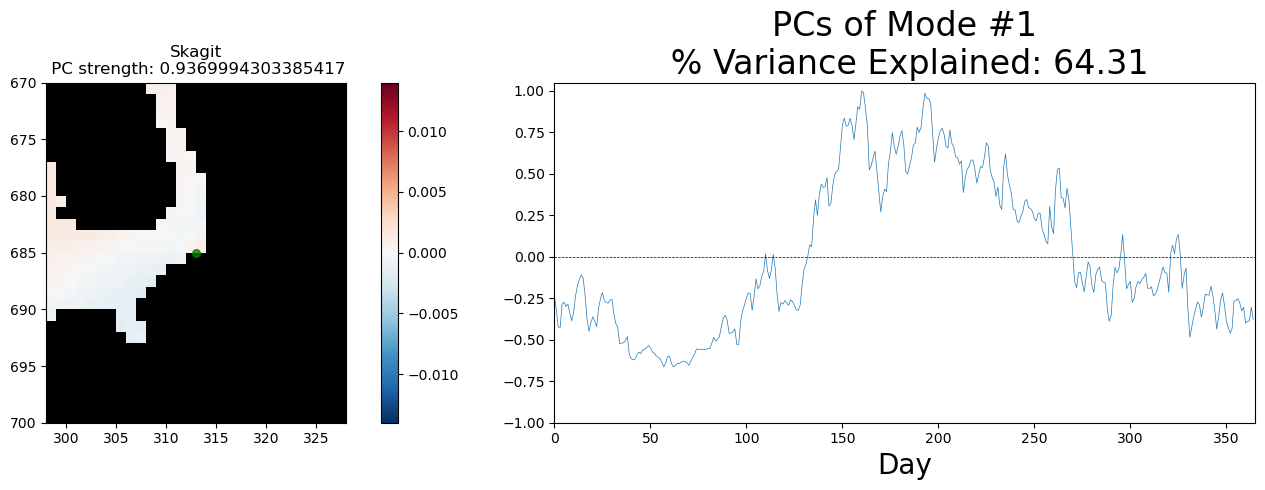

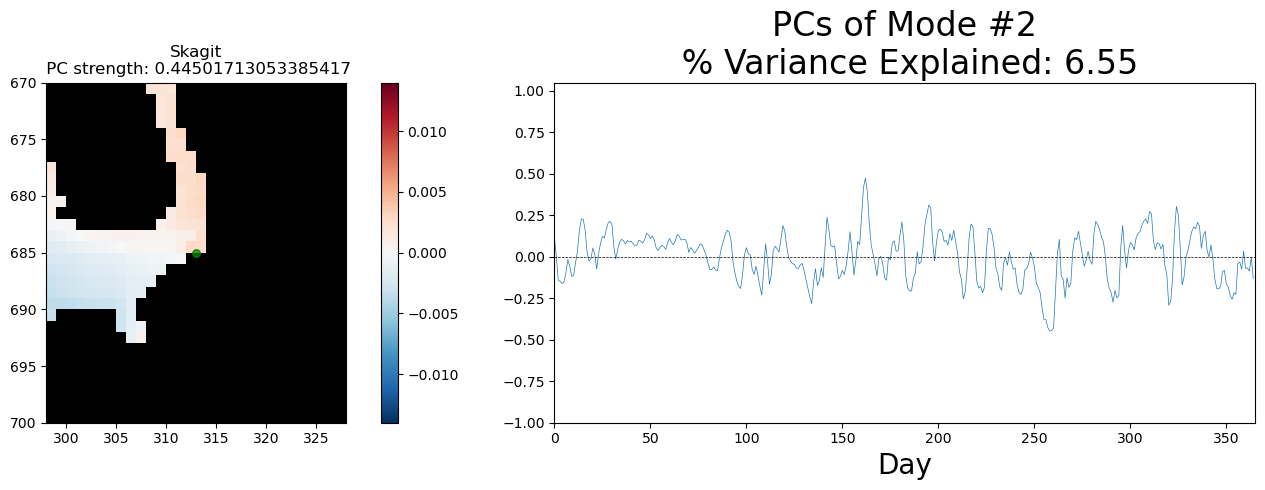

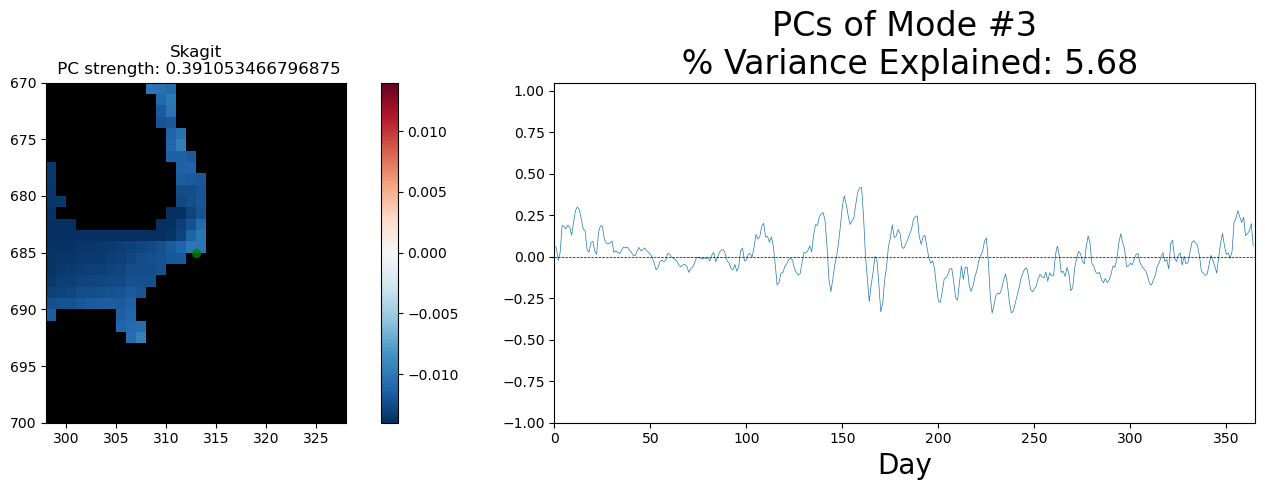

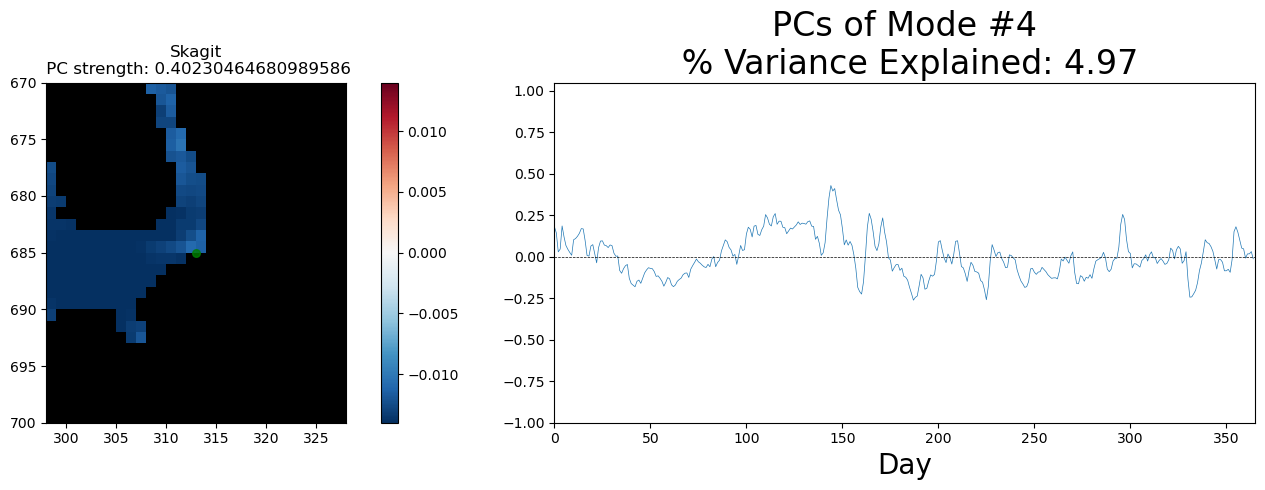

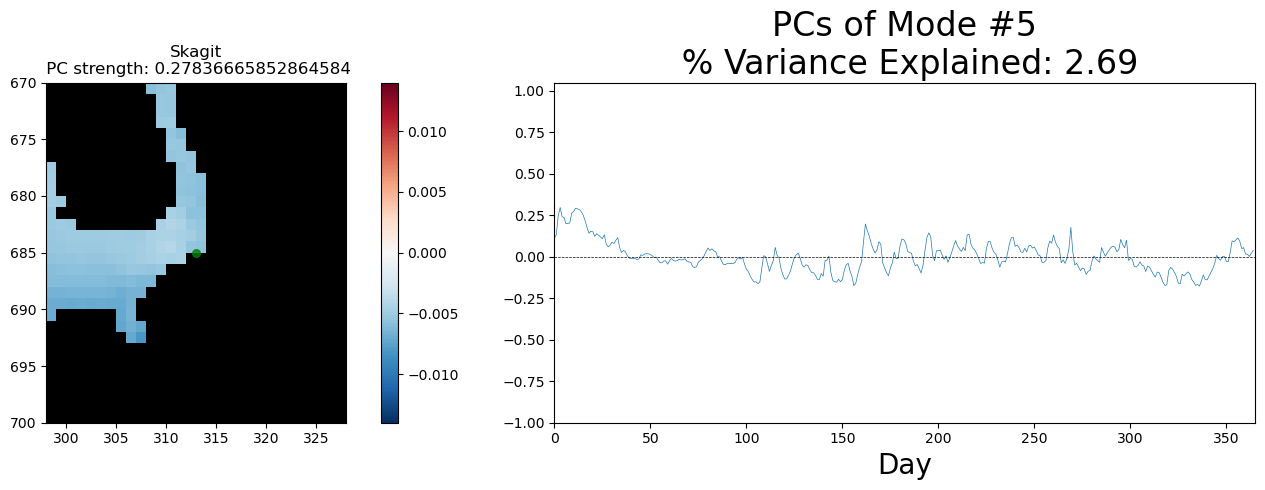

In [20]:
river_zoom('skagit','Skagit1','Skagit',0)
river_zoom('skagit','Skagit1','Skagit',1)
river_zoom('skagit','Skagit1','Skagit',2)
river_zoom('skagit','Skagit1','Skagit',3)
river_zoom('skagit','Skagit1','Skagit',4)

## Plot all of them

In [38]:
def plot_head(w_shed, r_call, r_name):
    ax.scatter(rivers.prop_dict[w_shed][r_call]['j'], rivers.prop_dict[w_shed][r_call]['i'], s=30, color='tab:red',alpha=0.8,label=r_call)
    ax.text(rivers.prop_dict[w_shed][r_call]['j']+10, rivers.prop_dict[w_shed][r_call]['i'],r_name)
    print(r_name + ' (i, j): (' + str(rivers.prop_dict[w_shed][r_call]['i']) + ', ' + str(rivers.prop_dict[w_shed][r_call]['j']) + ')')
    print(' (di, dj): (' + str(rivers.prop_dict[w_shed][r_call]['di']) + ', ' + str(rivers.prop_dict[w_shed][r_call]['dj']) + ')')
    print(' depth: ' + str(rivers.prop_dict[w_shed][r_call]['depth']) + ' (m)\n')

Nisqually (i, j): (1, 135)
 (di, dj): (1, 1)
 depth: 1 (m)

Squamish (i, j): (534, 384)
 (di, dj): (1, 2)
 depth: 2 (m)

Homathko (i, j): (896, 293)
 (di, dj): (1, 3)
 depth: 2 (m)

Elwha (i, j): (261, 134)
 (di, dj): (1, 1)
 depth: 1 (m)

Cowichan (i, j): (383, 201)
 (di, dj): (1, 1)
 depth: 1 (m)

Stillaguamish (i, j): (183, 308)
 (di, dj): (1, 1)
 depth: 1 (m)

Puyallup (i, j): (11, 194)
 (di, dj): (1, 1)
 depth: 1 (m)

Nooksack (i, j): (308, 356)
 (di, dj): (1, 2)
 depth: 1 (m)

Skagit (i, j): (213, 313)
 (di, dj): (1, 1)
 depth: 2 (m)

Salmon (i, j): (865, 64)
 (di, dj): (1, 1)
 depth: 1 (m)

Fraser (i, j): (500, 394)
 (di, dj): (1, 1)
 depth: 3 (m)



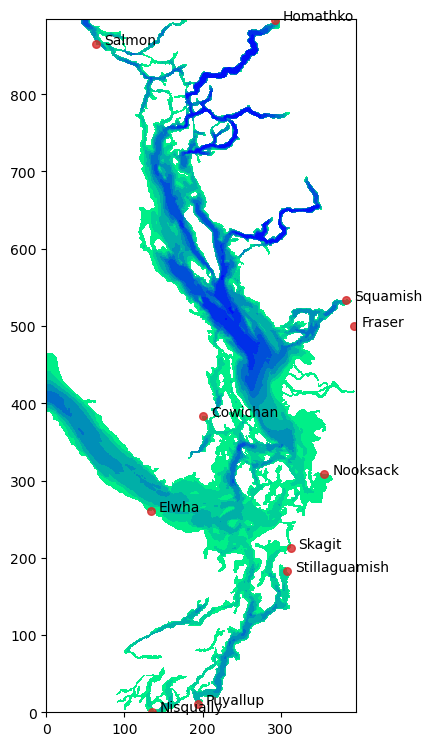

In [39]:
imin, imax = 0, 898
jmin, jmax = 0, 398
jj = range(jmax)
ii = range(imax)
jjm, iim = np.meshgrid(jj, ii)
# fluxarray = np.array(runoff.rorunoff[0, :, :jmax])
fig, ax = plt.subplots(1, 1, figsize=(4, 9))
ax.contourf(bathymetry.Bathymetry[:, :jmax], cmap='winter_r')
      
# ax.scatter(jjm[fluxarray>0], iim[fluxarray>0], s=fluxarray[fluxarray>0]*1000, color='tab:red',alpha=0.5)

plot_head('puget','NisquallyMcAllister','Nisqually')
plot_head('howe','Squamish','Squamish')
plot_head('bute','Homathko','Homathko')
plot_head('jdf','Elwha','Elwha')
# plot_head('evi_s','Nanaimo1','Nanaimo')  # others
plot_head('evi_s','Cowichan1','Cowichan')  # others
plot_head('skagit','Stillaguamish1','Stillaguamish')  # others
plot_head('puget','Puyallup','Puyallup')
# plot_head('fraser','LittleCampbell','Campbell')
plot_head('fraser','Nooksack','Nooksack')  # others
# plot_head('skagit','SnohomishAllenQuilceda','Snohomish')
plot_head('skagit','Skagit1','Skagit')  # others
plot_head('evi_n','SalmonSayward','Salmon')
plot_head('fraser','Fraser','Fraser')

In [51]:
def zoom_compare(w_shed, r_call, r_name, n):
    river_idx = [rivers.prop_dict[w_shed][r_call]['i'], rivers.prop_dict[w_shed][r_call]['j']]
    river_range = [river_idx[0] - 15, river_idx[0] + 15, river_idx[1] - 15, river_idx[1] + 15]

    if (river_range[0] < 0):
        river_range[0] = 0
        river_range[1] = 30

    if (898 - river_range[1] < 0):
        river_range[0] = 898-30
        river_range[1] = 898

    #plot the first n modes and PCs -- choose a value of 'n' from the variance explained figure
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    to_show = np.ma.masked_array(np.flipud(np.reshape(eigvecs[n],(Ny,Nx))), mask=tmask[0])
    cb = ax[0].pcolormesh(np.flipud(np.reshape(eigvecs[n],(Ny,Nx))), cmap='RdBu_r',vmin=-0.014,vmax=0.014)
    plt.colorbar(cb)
    cb2 = ax[0].pcolormesh(np.flipud(land), cmap='gray')  ################## want
    viz_tools.set_aspect(ax[0]);
    ax[0].set_xlim(river_range[2], river_range[3])
    ax[0].set_ylim(Ny-river_range[0], Ny-river_range[1])
    ax[0].scatter(river_idx[1], Ny-river_idx[0], s=30, color='g',alpha=0.8)
    ax[0].set_title(r_name + '\n PC strength: ' + str(PCs[:,n].max()/1500))


    ax[1].plot(PCs[:,n]/max_pc, linewidth = 0.5)
    ax[1].plot([0,num_days], [0,0],'k--',linewidth = 0.5)
    ax[1].set_title('PCs of Mode #' + str(n+1) + "\n % Variance Explained: " + str(round(100*fracVar[n],2)), fontsize = 24)
    ax[1].set_xlabel('Day', fontsize = 20)
    ax[1].set_ylim([-1,1.05])
    ax[1].set_xlim([0,num_days])
        
    plt.tight_layout()
    # plt.show()
    plt.close(fig)
    return fig

In [52]:
figure = zoom_compare('skagit','Skagit1','Skagit',0)

In [75]:
def plot_zoom(w_shed, r_call, r_name, n, plot_i, plot_j):
    # to_show = np.ma.masked_array(np.flipud(np.reshape(eigvecs[n],(Ny,Nx))), mask=tmask[0])
    cb = ax[plot_i, plot_j].pcolormesh(np.flipud(np.reshape(eigvecs[n],(Ny,Nx))), cmap='RdBu_r',vmin=-0.014,vmax=0.014)
    # plt.colorbar(cb)
    cb2 = ax[plot_i, plot_j].pcolormesh(np.flipud(land), cmap='gray')

    river_idx = [rivers.prop_dict[w_shed][r_call]['i'], rivers.prop_dict[w_shed][r_call]['j']]
    river_range = [river_idx[0] - 15, river_idx[0] + 15, river_idx[1] - 15, river_idx[1] + 15]

    if (river_range[0] < 0):
        river_range[0] = 0
        river_range[1] = 30

    if (898 - river_range[1] < 0):
        river_range[0] = 898-30
        river_range[1] = 898

    viz_tools.set_aspect(ax[plot_i, plot_j]);
    ax[plot_i, plot_j].set_xlim(river_range[2], river_range[3])
    ax[plot_i, plot_j].set_ylim(Ny-river_range[0], Ny-river_range[1])
    ax[plot_i, plot_j].scatter(river_idx[1], Ny-river_idx[0], s=30, color='g',alpha=0.8)
    ax[plot_i, plot_j].set_title(r_name)

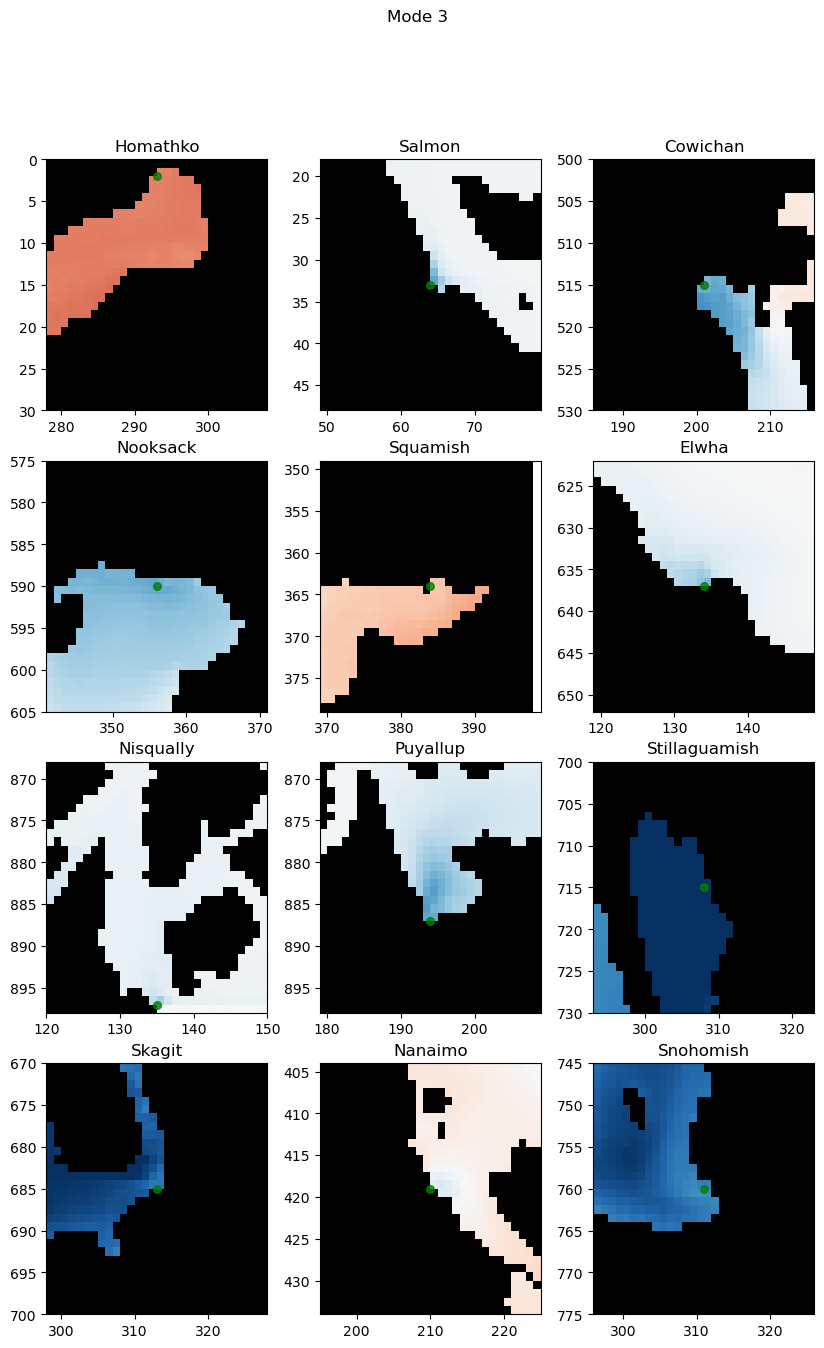

In [93]:
# Look at all of them
n=2
fig, ax = plt.subplots(4, 3, figsize=(10, 15))
plt.suptitle('Mode ' + str(n + 1))

plot_zoom('bute', 'Homathko', 'Homathko', n, 0, 0)
plot_zoom('evi_n', 'SalmonSayward', 'Salmon', n, 0, 1)
plot_zoom('evi_s','Cowichan1','Cowichan', n, 0, 2)
plot_zoom('fraser','Nooksack','Nooksack', n, 1, 0)
plot_zoom('howe','Squamish','Squamish', n, 1, 1)
plot_zoom('jdf','Elwha','Elwha', n, 1, 2)
plot_zoom('puget','NisquallyMcAllister','Nisqually', n, 2, 0)
plot_zoom('puget','Puyallup','Puyallup', n, 2, 1)
plot_zoom('skagit','Stillaguamish1','Stillaguamish', n, 2, 2)
plot_zoom('skagit','Skagit1','Skagit', n, 3, 0)

plot_zoom('evi_s','Nanaimo1','Nanaimo', n, 3, 1)  # others
# plot_zoom('fraser','LittleCampbell','Campbell', n, )
plot_zoom('skagit','SnohomishAllenQuilceda','Snohomish', n, 3, 2)

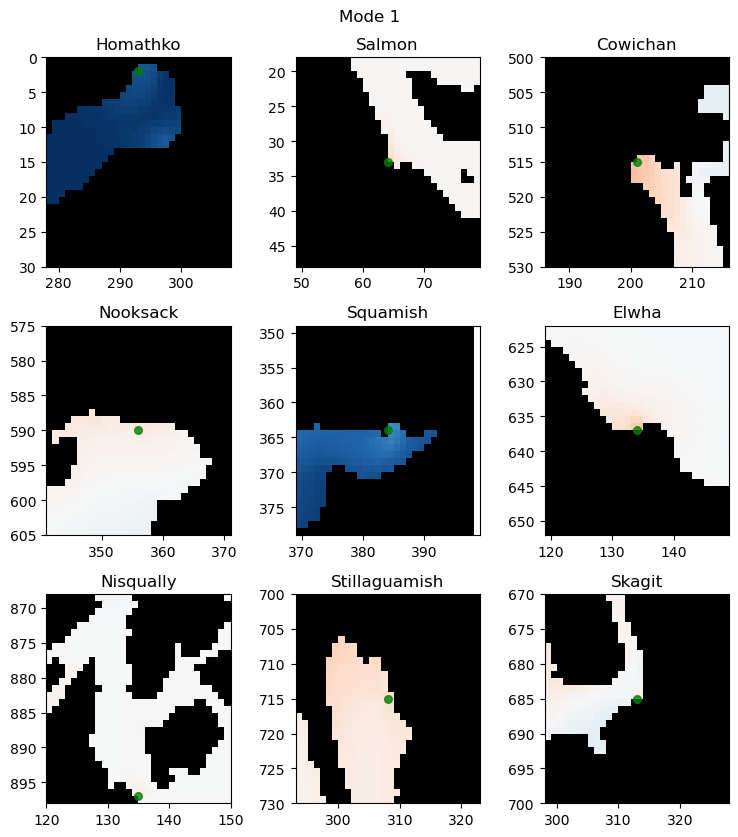

In [94]:
# Look at only selected
n=0
fig, ax = plt.subplots(3, 3, figsize=(7.5, 8.5))
plt.suptitle('Mode ' + str(n + 1))

plot_zoom('bute', 'Homathko', 'Homathko', n, 0, 0)
plot_zoom('evi_n', 'SalmonSayward', 'Salmon', n, 0, 1)
plot_zoom('evi_s','Cowichan1','Cowichan', n, 0, 2)
plot_zoom('fraser','Nooksack','Nooksack', n, 1, 0)
plot_zoom('howe','Squamish','Squamish', n, 1, 1)
plot_zoom('jdf','Elwha','Elwha', n, 1, 2)
plot_zoom('puget','NisquallyMcAllister','Nisqually', n, 2, 0)
plot_zoom('skagit','Stillaguamish1','Stillaguamish', n, 2, 1)
plot_zoom('skagit','Skagit1','Skagit', n, 2, 2)

plt.tight_layout()